# Wind Data Analysis - 3D Anemometer vs NAM Forecast Data
 

## Clean Data 

In [58]:
# Dependencies and Setup
import pandas as pd
from datetime import datetime, timedelta 
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as st # for linear regression model
from scipy.stats import ttest_ind, ttest_rel
from matplotlib.colors import LinearSegmentedColormap

# Read in data
data_3d = pd.read_csv('data/3d_anemometer.csv') # 3d anemometer
data_nam = pd.read_csv('data/nam_wind_data.csv') # NAM data

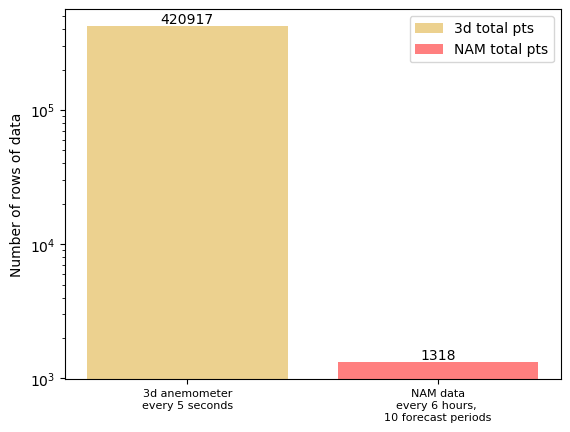

In [59]:
# Histogram of dataset sizes
dataset_sizes = [len(data_3d),len(data_nam)]
bars = plt.bar(['3d anemometer\nevery 5 seconds',
                 f'NAM data\nevery 6 hours, \n{len(data_nam["forecast_period"].unique())} forecast periods'], 
                 dataset_sizes, color=["goldenrod","red"],alpha=0.5,
                 label=["3d total pts","NAM total pts"])
# plt.xlabel('dataset')
plt.xticks(fontsize=8)
plt.ylabel('Number of rows of data')
plt.yscale('log')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
             ha='center', va='bottom')  # va='bottom' to place label above the bar
plt.savefig("output/raw_data_number_data_points.png", bbox_inches='tight')
plt.show()

In [60]:
# Column names
print(data_3d.columns)
print(data_nam.columns)

Index(['_id', 'n_pts', 'temp', 'time_utc', 'wdr', 'welv', 'wspd',
       'Origin of data', 'c.date', 'c.hour', 'c.minute', 'c.second',
       'c.second_bin'],
      dtype='object')
Index(['time_utc', 'forecast_period', 'wspd', 'wdr', 'welv', 'temp_C',
       'kinetic_e'],
      dtype='object')


In [61]:
# Change time_utc to datetime
data_3d = data_3d.astype({
                'time_utc': 'datetime64[ns]',
                })
data_nam = data_nam.astype({
                'time_utc': 'datetime64[ns]'
                })

In [62]:
# Add seconds to the time_utc (seconds were not in original time_utc)
data_3d['time_utc'] = data_3d['time_utc'] + pd.to_timedelta(data_3d['c.second'], unit='s')

In [63]:
# Drop some columns
data_3d.drop(columns=['_id', 'Origin of data', 'c.date','c.hour', 'c.minute', 'c.second', 'c.second_bin'], inplace=True)

In [64]:
# Rename columns 
data_3d.rename(columns={
                   'temp':'temp_C',
                   'wspd':'wspd_mps',
                   },
                   inplace=True)
data_nam.rename(columns={
                   'wspd':'wspd_mps',
                   },
                   inplace=True)

In [65]:
# Drop null values
data_3d.dropna(subset=['time_utc', 'wdr', 'wspd_mps'], inplace=True)
data_nam.dropna(subset=['time_utc', 'wdr', 'wspd_mps'], inplace=True)

In [66]:
# Show info about the dataset
data_3d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420917 entries, 0 to 420916
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   n_pts     420917 non-null  int64         
 1   temp_C    420917 non-null  float64       
 2   time_utc  420917 non-null  datetime64[ns]
 3   wdr       420917 non-null  float64       
 4   welv      420915 non-null  float64       
 5   wspd_mps  420917 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 19.3 MB


In [67]:
# Show info about the dataset
data_nam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_utc         1318 non-null   datetime64[ns]
 1   forecast_period  1318 non-null   int64         
 2   wspd_mps         1318 non-null   float64       
 3   wdr              1318 non-null   float64       
 4   welv             1318 non-null   float64       
 5   temp_C           1318 non-null   float64       
 6   kinetic_e        1318 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 72.2 KB


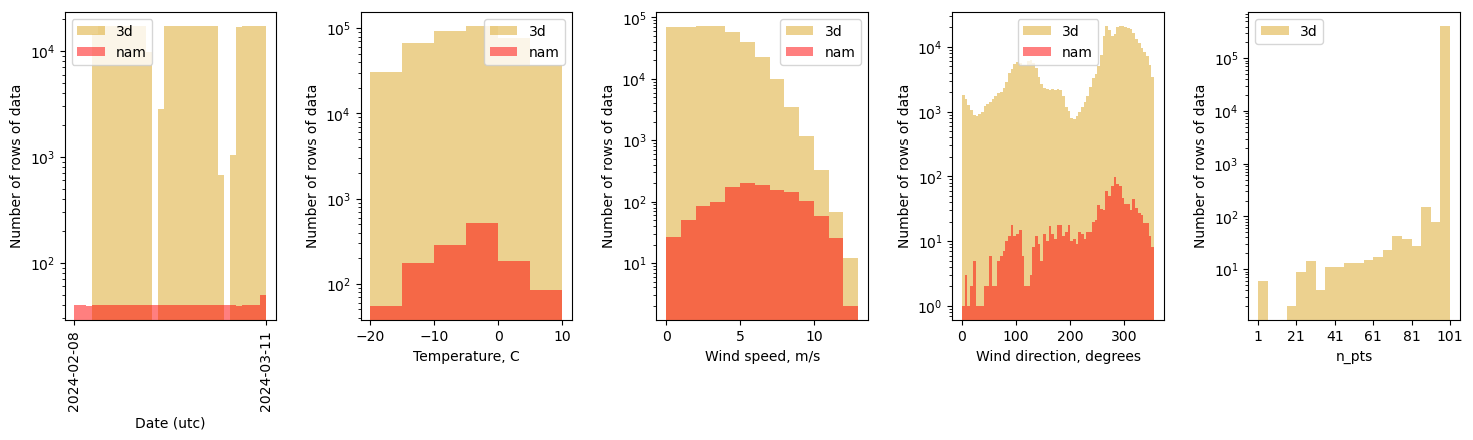

In [68]:
# Histograms of raw data

fig, axes = plt.subplots(1,5, figsize=(18,4))
fig.subplots_adjust(wspace=.4)

ax = axes[0]
# Create a list of dates
start_date = min(min(data_3d['time_utc'].dt.date), min(data_nam['time_utc'].dt.date))
end_date = max(max(data_3d['time_utc'].dt.date), max(data_nam['time_utc'].dt.date))
dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end_date - start_date).days + 1)]
# Plot histogram
ax.hist(data_3d['time_utc'], bins = dates, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['time_utc'], bins = dates, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Date (utc)')  
ax.set_xticks([dates[0], dates[len(dates)-1]])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of temperature
ax = axes[1]
start_bin = int(np.floor(min(min(data_3d['temp_C']), min(data_nam['temp_C']))))
end_bin = int(np.ceil(max(max(data_3d['temp_C']), max(data_nam['temp_C']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['temp_C'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['temp_C'], bins=bin_limits, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Temperature, C')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind speeds
ax = axes[2]
start_bin = int(np.floor(min(min(data_3d['wspd_mps']), min(data_nam['wspd_mps']))))
end_bin = int(np.ceil(max(max(data_3d['wspd_mps']), max(data_nam['wspd_mps']))))
bin_limits = list(range(start_bin,end_bin, 1))
# Plot histogram
ax.hist(data_3d['wspd_mps'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['wspd_mps'], bins=bin_limits, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Wind speed, m/s')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind directions
ax = axes[3]
start_bin = int(np.floor(min(min(data_3d['wdr']), min(data_nam['wdr']))))
end_bin = int(np.ceil(max(max(data_3d['wdr']), max(data_nam['wdr']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['wdr'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['wdr'], bins=bin_limits, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Wind direction, degrees')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()

# Histogram of n_pts
ax = axes[4]
start_bin = int(np.floor(min(data_3d['n_pts'])))
end_bin = int(np.ceil(max(data_3d['n_pts'])))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['n_pts'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.set_xlabel('n_pts')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.set_xticks(list(range(start_bin,end_bin, 20)))
ax.legend()

plt.savefig("output/raw_data_histograms.png", bbox_inches='tight')
plt.show()

In [69]:
# Remove rows where less than 5 data points used to compute measurement
data_3d = data_3d[data_3d['n_pts']>=5]

In [70]:
# Check for duplicated data
print(data_3d.duplicated().sum())
print(data_nam.duplicated().sum())

0
0


In [71]:
# Find horizontal component of wind speed for 3d anemometer
data_3d["wspd_mps"] = np.cos(data_3d["welv"]*math.pi/180)*data_3d["wspd_mps"]

In [72]:
# Correct nam wind speed for height, using wind shear formula
# https://wind-data.ch/tools/profile.php
h_2 = 3.0 # height of 3d anemometer = 10 feet 
h_1 = 80 # height of nam data = planetaryBoundaryLayer:level 0 
# z_0 = 0.0024 # Open terrain with smooth surfaces, e.g. concrete, airport runways, mown grass, etc.
z_0 = 0.03 # Open agricultural land without fences and hedges, possibly with widely scattered buildings and very gentle hills
shear_correction = np.log10(h_2/z_0) / np.log10(h_1/z_0)
data_nam["wspd_mps"] = data_nam["wspd_mps"]*shear_correction
shear_correction

0.5837764895984604

In [73]:
# Reset index if any data was removed
data_3d = data_3d.reset_index(drop=True)
data_nam = data_nam.reset_index(drop=True)

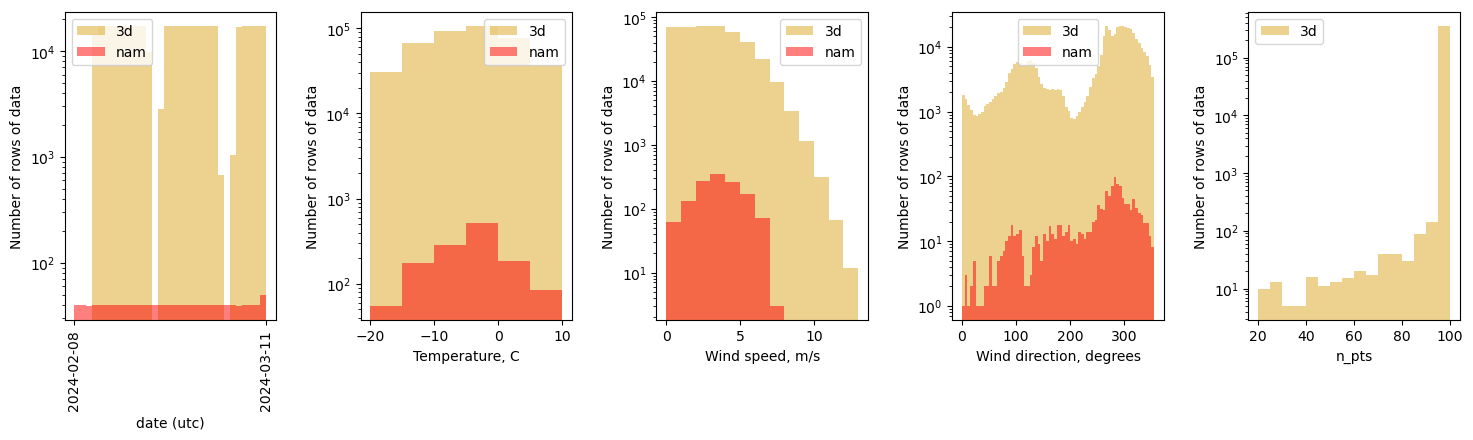

In [74]:
# Histograms of cleaned data

fig, axes = plt.subplots(1,5, figsize=(18,4))
fig.subplots_adjust(wspace=.4)

ax = axes[0]
# Create a list of dates
start_date = min(min(data_3d['time_utc'].dt.date), min(data_nam['time_utc'].dt.date))
end_date = max(max(data_3d['time_utc'].dt.date), max(data_nam['time_utc'].dt.date))
dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end_date - start_date).days + 1)]
# Plot histogram
ax.hist(data_3d['time_utc'], bins = dates, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['time_utc'], bins = dates, color="red", label="nam", alpha=0.5)
ax.set_xlabel('date (utc)')  
ax.set_xticks([dates[0], dates[len(dates)-1]])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of temperature
ax = axes[1]
start_bin = int(np.floor(min(min(data_3d['temp_C']), min(data_nam['temp_C']))))
end_bin = int(np.ceil(max(max(data_3d['temp_C']), max(data_nam['temp_C']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['temp_C'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['temp_C'], bins=bin_limits, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Temperature, C')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind speeds
ax = axes[2]
start_bin = int(np.floor(min(min(data_3d['wspd_mps']), min(data_nam['wspd_mps']))))
end_bin = int(np.ceil(max(max(data_3d['wspd_mps']), max(data_nam['wspd_mps']))))
bin_limits = list(range(start_bin,end_bin, 1))
# Plot histogram
ax.hist(data_3d['wspd_mps'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['wspd_mps'], bins=bin_limits, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Wind speed, m/s')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind directions
ax = axes[3]
start_bin = int(np.floor(min(min(data_3d['wdr']), min(data_nam['wdr']))))
end_bin = int(np.ceil(max(max(data_3d['wdr']), max(data_nam['wdr']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['wdr'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['wdr'], bins=bin_limits, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Wind direction, degrees')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()

# Histogram of n_pts
ax = axes[4]
start_bin = int(np.floor(min(data_3d['n_pts'])))
end_bin = int(np.ceil(max(data_3d['n_pts'])))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['n_pts'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.set_xlabel('n_pts')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.set_xticks(list(range(start_bin,end_bin, 20)))
ax.legend()


plt.savefig("output/cleaned_data_histograms_.png", bbox_inches='tight')
plt.show()

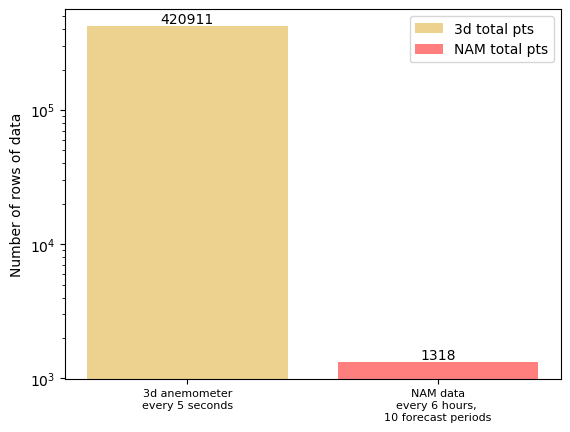

In [75]:
# Histogram of dataset sizes
dataset_sizes = [len(data_3d),len(data_nam)]
bars = plt.bar(['3d anemometer\nevery 5 seconds',
                 f'NAM data\nevery 6 hours, \n{len(data_nam["forecast_period"].unique())} forecast periods'], 
                 dataset_sizes, color=["goldenrod","red"],alpha=0.5,
                 label=["3d total pts","NAM total pts"])
# plt.xlabel('dataset')
plt.xticks(fontsize=8)
plt.ylabel('Number of rows of data')
plt.yscale('log')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
             ha='center', va='bottom')  # va='bottom' to place label above the bar
plt.savefig("output/cleaned_data_number_data_points.png", bbox_inches='tight')
plt.show()

In [76]:
# Save the cleaned data for future use
data_3d.to_csv('data/3d_anemometer_cleaned.csv', index=False)  
data_nam.to_csv('data/nam_wind_data_cleaned.csv', index=False)  

## Add columns
Add columns to be used for analysis.

In [77]:
# Read in data
#data_3d = pd.read_csv('data/3d_anemometer_cleaned.csv') # 3d anemometer, cleaned
#data_nam = pd.read_csv('data/nam_wind_data_cleaned.csv') # NAM data, cleaned

In [78]:
# Add local time, date, and hour to 3d anemometer data
data_3d['time_local'] = data_3d['time_utc'] - timedelta(hours=6)
data_3d['date'] = data_3d['time_local'].dt.date
data_3d = data_3d.astype({'date': 'datetime64[ns]'})
data_3d['hour'] = data_3d['time_local'].dt.hour
data_3d['minute'] = data_3d['time_local'].dt.minute

# Add local time, date, and hour to nam data
data_nam['time_local'] = data_nam['time_utc'] - timedelta(hours=6)
data_nam['date'] = data_nam['time_local'].dt.date
data_nam = data_nam.astype({'date': 'datetime64[ns]'})
data_nam['hour'] = data_nam['time_local'].dt.hour

# Date range 
print("Date range for 3d anemometer (local time):")
print(f"Min: {min(data_3d['time_local'])}")
print(f"Max: {max(data_3d['time_local'])}")
print("Date range for NAM data (local time):")
print(f"Min: {min(data_nam['time_local'])}")
print(f"Max: {max(data_nam['time_local'])}")

Date range for 3d anemometer (local time):
Min: 2024-02-10 21:44:04
Max: 2024-03-11 11:03:45
Date range for NAM data (local time):
Min: 2024-02-07 18:00:00
Max: 2024-03-11 12:00:00


In [79]:
# Establish the bins
minute_bin = list(np.arange(0,61,15)) # [0, 15, 30, 45, 60]

# Use `pd.cut` to find minute bins
data_3d["minute_bin"] = pd.cut(data_3d["minute"], 
                                bins = minute_bin, 
                                include_lowest = True,
                                right = False)

In [80]:
# Find hour and date of forecast
data_nam['hour_forecasted'] = data_nam['hour'] + data_nam['forecast_period']
data_nam['days_to_add'] = np.floor(data_nam['hour_forecasted'] / 24)
data_nam['days_to_add'] = pd.to_timedelta(data_nam['days_to_add'],'d')
data_nam['date_forecasted'] = data_nam['date'] + data_nam['days_to_add']
data_nam['hour_forecasted'] = data_nam['hour_forecasted'] % 24

In [82]:
# Find cosine and sine of wind directions (for future averaging using vector components)
data_3d["wdr_cos"] = np.cos(data_3d["wdr"]*math.pi/180)
data_3d["wdr_sin"] = np.sin(data_3d["wdr"]*math.pi/180)
data_nam["wdr_cos"] = np.cos(data_nam["wdr"]*math.pi/180)
data_nam["wdr_sin"] = np.sin(data_nam["wdr"]*math.pi/180)

In [83]:
# Add a column for temperature in Fahrenheit
data_3d["temp_F"] = data_3d["temp_C"]*1.8+32
data_nam["temp_F"] = data_nam["temp_C"]*1.8+32
# Add a column for wind speed in mph
data_3d["wspd_mph"] = data_3d["wspd_mps"]*2.23694
data_nam["wspd_mph"] = data_nam["wspd_mps"]*2.23694

In [84]:
# Show first five rows
data_3d.head()

n_pts  temp_C            time_utc     wdr  welv  wspd_mps  \
0    102   -7.18 2024-02-20 13:36:40  301.86 -3.15  0.479275   
1    100   -7.16 2024-02-20 13:36:35  308.80 -0.70  0.379972   
2    100   -7.13 2024-02-20 13:36:30  313.35 -4.28  0.398884   
3     99   -7.16 2024-02-20 13:36:25  321.01 -4.78  0.488296   
4     98   -7.17 2024-02-20 13:36:20  323.81 -1.89  0.579684   

           time_local       date  hour  minute minute_bin   wdr_cos   wdr_sin  \
0 2024-02-20 07:36:40 2024-02-20     7      36   [30, 45)  0.527846 -0.849340   
1 2024-02-20 07:36:35 2024-02-20     7      36   [30, 45)  0.626604 -0.779338   
2 2024-02-20 07:36:30 2024-02-20     7      36   [30, 45)  0.686453 -0.727174   
3 2024-02-20 07:36:25 2024-02-20     7      36   [30, 45)  0.777256 -0.629185   
4 2024-02-20 07:36:20 2024-02-20     7      36   [30, 45)  0.807063 -0.590465   

   temp_F  wspd_mph  
0  19.076  1.072109  
1  19.112  0.849974  
2  19.166  0.892281  
3  19.112  1.092288  
4  19.094  1.296719

In [85]:
# Show first five rows
data_nam.head()

time_utc  forecast_period  wspd_mps        wdr      welv    temp_C  \
0 2024-02-08                0  2.834851  53.385763 -0.148575 -0.297461   
1 2024-02-08                1  2.579869  45.718757  0.144892 -0.441577   
2 2024-02-08                2  2.301608  36.174609 -0.187564 -0.437842   
3 2024-02-08                3  2.412921  24.822946  0.279599 -0.465015   
4 2024-02-08                4  2.647850  15.952962 -0.101502 -0.503418   

   kinetic_e          time_local       date  hour  hour_forecasted  \
0        0.6 2024-02-07 18:00:00 2024-02-07    18               18   
1        0.5 2024-02-07 18:00:00 2024-02-07    18               19   
2        0.4 2024-02-07 18:00:00 2024-02-07    18               20   
3        0.4 2024-02-07 18:00:00 2024-02-07    18               21   
4        0.5 2024-02-07 18:00:00 2024-02-07    18               22   

  days_to_add date_forecasted   wdr_cos   wdr_sin     temp_F  wspd_mph  
0      0 days      2024-02-07  0.596424  0.802669  31.464570  6.341391  
1      0 days      2024-02-07  0.698181  0.715921  31.205161  5.771013  
2      0 days      2024-02-07  0.807222  0.590248  31.211885  5.148559  
3      0 days      2024-02-07  0.907609  0.419816  31.162974  5.397560  
4      0 days      2024-02-07  0.961488  0.274848  31.093848  5.923082

## Join data on 15-min intervals for 3d anemometer (since that is the interval of LongPath anemometer averaging)

In [86]:
# Average wind speed and wind direction over 15 min intervals
data_3d_15min = data_3d.groupby(['date', 'hour','minute_bin'],as_index=False,observed=False)[['wspd_mps','wspd_mph','wdr_cos','wdr_sin','welv','temp_C','temp_F']].mean()
data_3d_15min.dropna(inplace=True)

# Compute wind direction from vector components
data_3d_15min['wdr'] = (np.arctan2(data_3d_15min['wdr_sin'],data_3d_15min['wdr_cos']) * 180 / np.pi) % 360


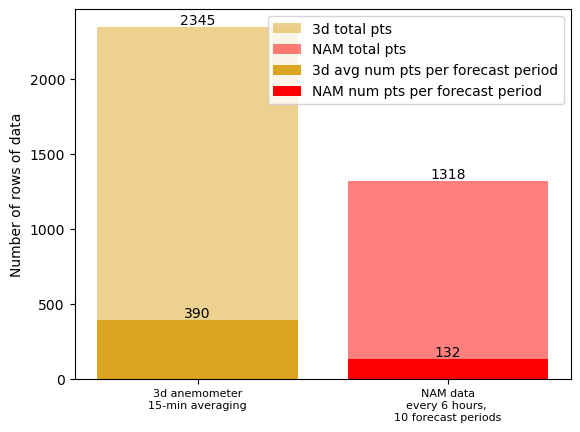

In [87]:
# Histogram of dataset sizes

dataset1_sizes = [len(data_3d_15min),len(data_nam)]
dataset2_sizes = [len(data_3d_15min)/6,len(data_nam[data_nam['forecast_period']==0])]
bars = plt.bar(['3d anemometer\n15-min averaging', 
                f'NAM data\nevery 6 hours, \n{len(data_nam["forecast_period"].unique())} forecast periods'],
                 dataset1_sizes, color=["goldenrod","red"], alpha=.5,
                 label=["3d total pts","NAM total pts"])
bars2 = plt.bar(['3d anemometer\n15-min averaging',
                 f'NAM data\nevery 6 hours, \n{len(data_nam["forecast_period"].unique())} forecast periods'], 
                 dataset2_sizes, color=["goldenrod","red"], alpha=1,
                 label=["3d avg num pts per forecast period","NAM num pts per forecast period"])
#plt.xlabel('dataset')
plt.xticks(fontsize=8)
plt.legend()
plt.ylabel('Number of rows of data')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
             ha='center', va='bottom')  # va='bottom' to place label above the bar
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
             ha='center', va='bottom')  # va='bottom' to place label above the bar
plt.savefig("output/cleaned_data_15_min_avg_number_data_points.png", bbox_inches='tight')
plt.show()

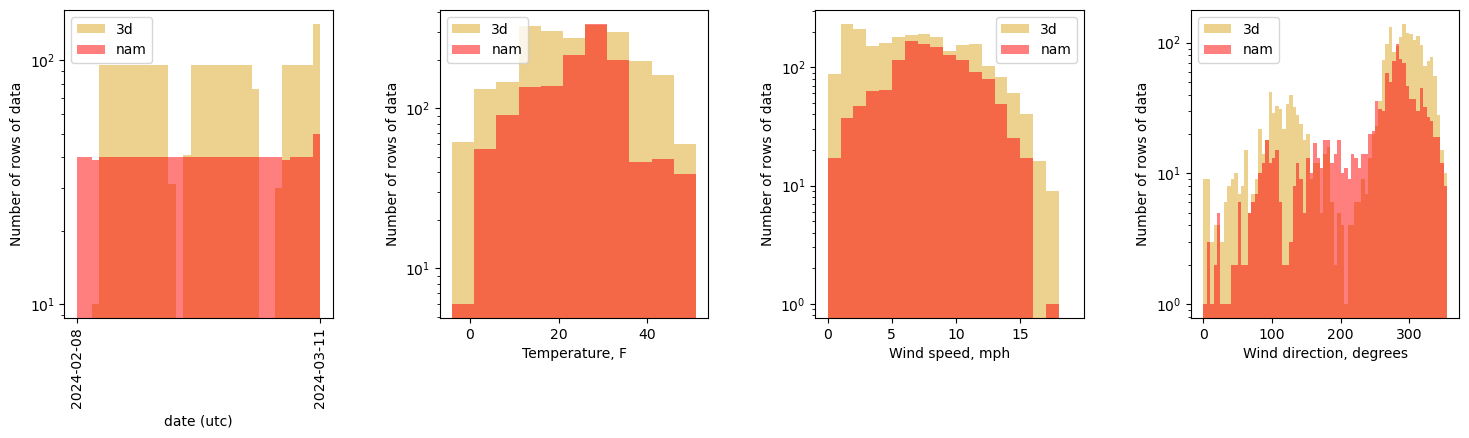

In [88]:
# Histograms of 15-minute data

fig, axes = plt.subplots(1,4, figsize=(18,4))
fig.subplots_adjust(wspace=.4)

ax = axes[0]
# Create a list of dates
start_date = min(min(data_3d_15min['date'].dt.date), min(data_nam['time_utc'].dt.date))
end_date = max(max(data_3d_15min['date'].dt.date), max(data_nam['time_utc'].dt.date))
dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end_date - start_date).days + 1)]
# Plot histogram
ax.hist(data_3d_15min['date'], bins = dates, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['time_utc'], bins = dates, color="red", label="nam", alpha=0.5)
ax.set_xlabel('date (utc)')  
ax.set_xticks([dates[0], dates[len(dates)-1]])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of temperature
ax = axes[1]
start_bin = int(np.floor(min(min(data_3d_15min['temp_F']), min(data_nam['temp_F']))))
end_bin = int(np.ceil(max(max(data_3d_15min['temp_F']), max(data_nam['temp_F']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d_15min['temp_F'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['temp_F'], bins=bin_limits, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Temperature, F')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind speeds
ax = axes[2]
start_bin = int(np.floor(min(min(data_3d_15min['wspd_mph']), min(data_nam['wspd_mph']))))
end_bin = int(np.ceil(max(max(data_3d_15min['wspd_mph']), max(data_nam['wspd_mph']))))
bin_limits = list(range(start_bin,end_bin, 1))
# Plot histogram
ax.hist(data_3d_15min['wspd_mph'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['wspd_mph'], bins=bin_limits, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Wind speed, mph')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind directions
ax = axes[3]
start_bin = int(np.floor(min(min(data_3d_15min['wdr']), min(data_nam['wdr']))))
end_bin = int(np.ceil(max(max(data_3d_15min['wdr']), max(data_nam['wdr']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d_15min['wdr'], bins=bin_limits, color="goldenrod", label="3d", alpha=0.5)
ax.hist(data_nam['wdr'], bins=bin_limits, color="red", label="nam", alpha=0.5)
ax.set_xlabel('Wind direction, degrees')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()

plt.savefig("output/binned_data_histograms_.png", bbox_inches='tight')
plt.show()

In [89]:
# Check that wind direction calculation works as expected
demo_angle = 333
demo_sin_angle = np.sin(demo_angle*math.pi/180)
demo_cos_angle = np.cos(demo_angle*math.pi/180)
demo_wdr1 = (np.arctan2(demo_sin_angle,demo_cos_angle) * 180 / np.pi) % 360
demo_wdr2 = (180/math.pi)*np.arctan(demo_sin_angle/demo_cos_angle)+(demo_cos_angle<0)*180+( (demo_cos_angle>=0) & (demo_sin_angle<0) )*360
print(demo_wdr1)
print(demo_wdr2)

333.0
333.0


In [90]:
# Check that wind direction calculation works as expected
demo_u = 1
demo_v = 1
demo_wdr3 = (np.arctan2(-demo_u,-demo_v) * 180 / np.pi) % 360
print(demo_wdr3)

225.0


In [91]:
# Merged dataframe of 3d anemometer and nam data
df_3d_and_nam = pd.merge(data_3d_15min, data_nam, how = 'outer', left_on = ['date','hour'], right_on = ['date_forecasted','hour_forecasted'], suffixes=('_3d', '_nam'))

# Compute columns comparing 3d anemometer and nam data
df_3d_and_nam['welv_diff'] = df_3d_and_nam['welv_nam'] - df_3d_and_nam['welv_3d']
df_3d_and_nam['wspd_mps_diff'] = df_3d_and_nam['wspd_mps_nam'] - df_3d_and_nam['wspd_mps_3d']
df_3d_and_nam['wspd_mph_diff'] = df_3d_and_nam['wspd_mph_nam'] - df_3d_and_nam['wspd_mph_3d']
df_3d_and_nam['wdr_diff'] = df_3d_and_nam['wdr_nam'] - df_3d_and_nam['wdr_3d'] + (df_3d_and_nam['wdr_nam'] - df_3d_and_nam['wdr_3d']<-180)*360 -  (df_3d_and_nam['wdr_nam'] - df_3d_and_nam['wdr_3d']>180)*360
df_3d_and_nam['temp_C_diff'] = df_3d_and_nam['temp_C_nam'] - df_3d_and_nam['temp_C_3d']
df_3d_and_nam['temp_F_diff'] = df_3d_and_nam['temp_F_nam'] - df_3d_and_nam['temp_F_3d']
df_3d_and_nam['wdr_nam_by10'] = round(df_3d_and_nam['wdr_nam'],-1)
df_3d_and_nam['wspd_mps_nam_by1'] = round(df_3d_and_nam['wspd_mps_nam'],0)
df_3d_and_nam['wspd_mph_nam_by1'] = round(df_3d_and_nam['wspd_mph_nam'],0)
df_3d_and_nam['kinetic_e_by1'] = round(df_3d_and_nam['kinetic_e'],0)
df_3d_and_nam['temp_F_nam_by1'] = round(df_3d_and_nam['temp_F_nam'],0)

# Remove nulls
# df_3d_and_nam.dropna(inplace=True)

In [92]:
# Add or subtract 360 from wind direction for regression
df_3d_and_nam['wdr_3d_corr'] = df_3d_and_nam['wdr_3d'] 
df_3d_and_nam['wdr_3d_corr'] = df_3d_and_nam['wdr_3d_corr'] + (df_3d_and_nam['wdr_3d_corr']-df_3d_and_nam['wdr_nam']<-180)*360 - (df_3d_and_nam['wdr_3d_corr']-df_3d_and_nam['wdr_nam']>180)*360


In [93]:
# Save the dataframes for use in multilinear regression 
df_3d_and_nam.to_csv('data/df_3d_and_nam.csv', index=False)  

## Analysis NAM vs 3d Anemometer

### Histograms of NAM - 3d difference

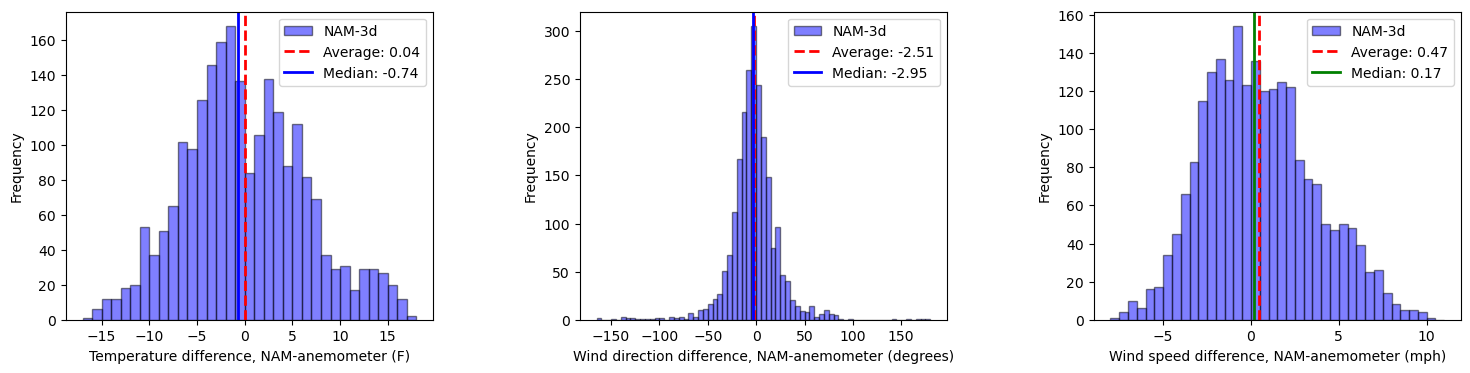

In [ ]:
# create filtering condition
condition3d = (df_3d_and_nam['forecast_period']<=12) & (df_3d_and_nam['wspd_mph_nam']>=2.24) & (df_3d_and_nam['wspd_mph_3d']>=2.24)

fig, axes = plt.subplots(1,3, figsize=(18,4))
fig.subplots_adjust(wspace=.4)

ax = axes[0]
data = df_3d_and_nam[condition3d]['temp_F_diff']
# Set desired bin width
bin_width = 1 
bin_edges = np.arange(np.floor(min(data)), np.ceil(max(data)) + bin_width, bin_width)
# Calculate the average and median
average = np.mean(data)
median = np.median(data)
# Histogram
ax.hist(data, bins=bin_edges, edgecolor='black', color='blue', alpha=0.5, label="NAM-3d")  # bins=30 creates 30 bins, adjust as needed
# Add vertical lines for the average and median
ax.axvline(average, color='r', linestyle='--', linewidth=2, label=f'Average: {average:.2f}')
ax.axvline(median, color='b', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
# Add title and labels
ax.set_xlabel('Temperature difference, NAM-anemometer (F)')
ax.set_ylabel('Frequency')
# Show legend
ax.legend()

ax = axes[1]
data = df_3d_and_nam[condition3d]['wdr_diff']
# Set desired bin width
bin_width = 5  
bin_edges = np.arange(np.floor(min(data)), np.ceil(max(data)) + bin_width, bin_width)
# Calculate the average and median
average = np.mean(data)
median = np.median(data)
# Histogram
ax.hist(data, bins=bin_edges, edgecolor='black', color='blue', alpha=0.5, label="NAM-3d")  # bins=30 creates 30 bins, adjust as needed
# Add vertical lines for the average and median
ax.axvline(average, color='r', linestyle='--', linewidth=2, label=f'Average: {average:.2f}')
ax.axvline(median, color='b', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
# Add title and labels
ax.set_xlabel('Wind direction difference, NAM-anemometer (degrees)')
ax.set_ylabel('Frequency')
# Show legend
ax.legend()

ax = axes[2]
data = df_3d_and_nam[condition3d]['wspd_mph_diff']
# Set desired bin width
bin_width = 0.5  
bin_edges = np.arange(np.floor(min(data)), np.ceil(max(data)) + bin_width, bin_width)
# Calculate the average and median
average = np.mean(data)
median = np.median(data)
# Histogram
ax.hist(data, bins=bin_edges, edgecolor='black', color='blue', alpha=0.5,label="NAM-3d")  # bins=30 creates 30 bins, adjust as needed
# Add vertical lines for the average and median
ax.axvline(average, color='r', linestyle='--', linewidth=2, label=f'Average: {average:.2f}')
ax.axvline(median, color='g', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
# Add title and labels
ax.set_xlabel('Wind speed difference, NAM-anemometer (mph)')
ax.set_ylabel('Frequency')
# Show legend
ax.legend()

plt.savefig("output/histogram_diff_3d_nam.png", bbox_inches='tight')
plt.show()

### NAM-3d difference for binned metrics

In [95]:
# Create dataframes of mean wind speed difference, wind direction difference, temp difference per NAM wind direction, wind speed, kinetic energy
diff_per_wdr_nam = df_3d_and_nam[df_3d_and_nam['forecast_period']<=12].groupby(['wdr_nam_by10'],as_index=False,observed=False)[['wspd_mps_diff','wspd_mph_diff','wdr_diff','temp_C_diff','temp_F_diff']].mean()
#diff_per_wspd_nam = df_3d_and_nam[df_3d_and_nam['forecast_period']<=12].groupby(['wspd_mps_nam'],as_index=False,observed=False)[['wspd_mps_diff','wdr_diff','temp_C_diff','temp_F_diff']].mean()
diff_per_wspd_nam = df_3d_and_nam[df_3d_and_nam['forecast_period']<=12].groupby(['wspd_mph_nam_by1'],as_index=False,observed=False)[['wspd_mph_diff','wdr_diff','temp_C_diff','temp_F_diff']].mean()
diff_per_kinetic_e_nam = df_3d_and_nam[df_3d_and_nam['forecast_period']<=12].groupby(['kinetic_e_by1'],as_index=False,observed=False)[['wspd_mps_diff','wspd_mph_diff','wdr_diff','temp_C_diff','temp_F_diff']].mean()
diff_per_temp_F_nam = df_3d_and_nam[df_3d_and_nam['forecast_period']<=12].groupby(['temp_F_nam_by1'],as_index=False,observed=False)[['wspd_mps_diff','wspd_mph_diff','wdr_diff','temp_C_diff','temp_F_diff']].mean()


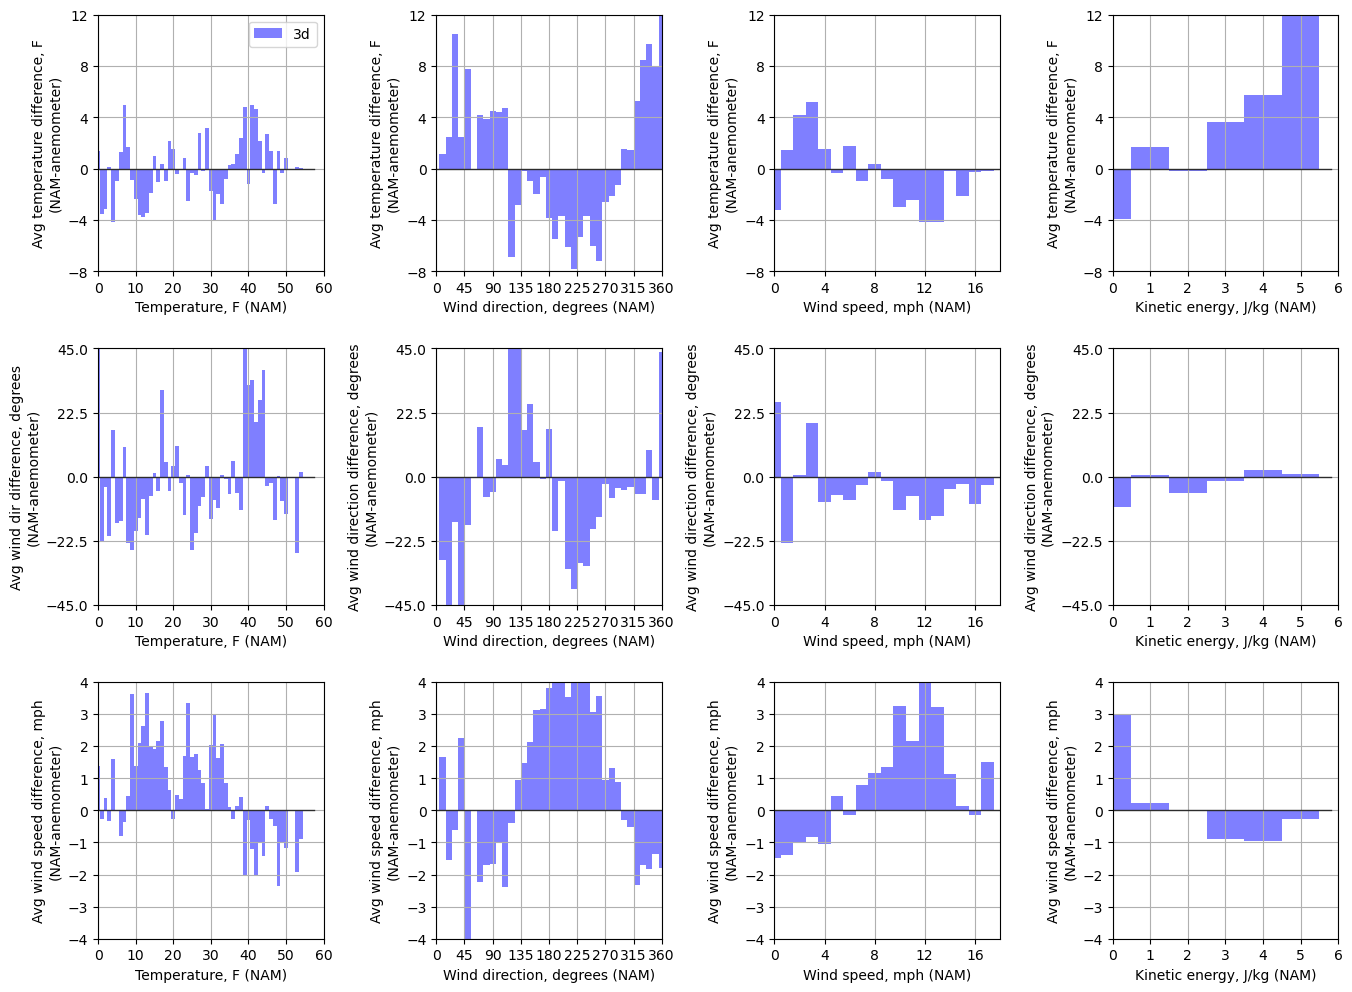

In [ ]:
# Column graphs of NAM-3d difference for binned metrics

fig, axes = plt.subplots(3,4, figsize=(16,12))
#fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.5)


ax = axes[0,0]
ax.bar(diff_per_temp_F_nam['temp_F_nam_by1'], diff_per_temp_F_nam['temp_F_diff'], width=1, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,60])
ax.set_xticks([0,10,20,30,40,50,60])
ax.set_ylim([-8,12])
ax.set_yticks([-8,-4, 0,4,8,12])
ax.grid(True) 
ax.set_xlabel('Temperature, F (NAM)')
ax.set_ylabel('Avg temperature difference, F\n(NAM-anemometer)')
ax.legend()

ax = axes[1,0]
ax.bar(diff_per_temp_F_nam['temp_F_nam_by1'], diff_per_temp_F_nam['wdr_diff'], width=1, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,60])
ax.set_xticks([0,10,20,30,40,50,60])
ax.set_ylim([-45,45])
ax.set_yticks([-45,-22.5,0,22.5,45])
ax.grid(True) 
ax.set_xlabel('Temperature, F (NAM)')
ax.set_ylabel('Avg wind dir difference, degrees\n(NAM-anemometer)')

ax = axes[2,0]
ax.bar(diff_per_temp_F_nam['temp_F_nam_by1'], diff_per_temp_F_nam['wspd_mph_diff'], width=1, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,60])
ax.set_xticks([0,10,20,30,40,50,60])
ax.set_ylim([-4,4])
ax.set_yticks([-4,-3,-2,-1,0,1,2,3,4])
ax.grid(True) 
ax.set_xlabel('Temperature, F (NAM)')
ax.set_ylabel('Avg wind speed difference, mph\n(NAM-anemometer)')



ax = axes[0,1]
ax.bar(diff_per_wdr_nam['wdr_nam_by10'], diff_per_wdr_nam['temp_F_diff'], width=10, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,360])
ax.set_xticks([0,45,90,135,180,225,270,315,360])
ax.set_ylim([-8,12])
ax.set_yticks([-8,-4, 0,4,8,12])
ax.grid(True) 
ax.set_xlabel('Wind direction, degrees (NAM)')
ax.set_ylabel('Avg temperature difference, F\n(NAM-anemometer)')

ax = axes[1,1]
ax.bar(diff_per_wdr_nam['wdr_nam_by10'], diff_per_wdr_nam['wdr_diff'], width=10, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,360])
ax.set_xticks([0,45,90,135,180,225,270,315,360])
ax.set_ylim([-45,45])
ax.set_yticks([-45,-22.5,0,22.5,45])
ax.grid(True) 
ax.set_xlabel('Wind direction, degrees (NAM)')
ax.set_ylabel('Avg wind direction difference, degrees\n(NAM-anemometer)')

ax = axes[2,1]
ax.bar(diff_per_wdr_nam['wdr_nam_by10'], diff_per_wdr_nam['wspd_mph_diff'], width=10, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,360])
ax.set_xticks([0,45,90,135,180,225,270,315,360])
ax.set_ylim([-4,4])
ax.set_yticks([-4,-3,-2,-1,0,1,2,3,4])
ax.grid(True) 
ax.set_xlabel('Wind direction, degrees (NAM)')
ax.set_ylabel('Avg wind speed difference, mph\n(NAM-anemometer)')

ax = axes[0,2]
ax.bar(diff_per_wspd_nam['wspd_mph_nam_by1'], diff_per_wspd_nam['temp_F_diff'], width=1, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,18])
ax.set_xticks([0,4,8,12,16])
ax.set_ylim([-8,12])
ax.set_yticks([-8,-4, 0,4,8,12])
ax.grid(True) 
ax.set_xlabel('Wind speed, mph (NAM)')
ax.set_ylabel('Avg temperature difference, F\n(NAM-anemometer)')

ax = axes[1,2]
ax.bar(diff_per_wspd_nam['wspd_mph_nam_by1'], diff_per_wspd_nam['wdr_diff'], width=1, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,18])
ax.set_xticks([0,4,8,12,16])
ax.set_ylim([-45,45])
ax.set_yticks([-45,-22.5,0,22.5,45])
ax.grid(True) 
ax.set_xlabel('Wind speed, mph (NAM)')
ax.set_ylabel('Avg wind direction difference, degrees\n(NAM-anemometer)')

ax = axes[2,2]
ax.bar(diff_per_wspd_nam['wspd_mph_nam_by1'], diff_per_wspd_nam['wspd_mph_diff'], width=1, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,18])
ax.set_xticks([0,4,8,12,16])
ax.set_ylim([-4,4])
ax.set_yticks([-4,-3,-2,-1,0,1,2,3,4])
ax.grid(True) 
ax.set_xlabel('Wind speed, mph (NAM)')
ax.set_ylabel('Avg wind speed difference, mph\n(NAM-anemometer)')


ax = axes[0,3]
ax.bar(diff_per_kinetic_e_nam['kinetic_e_by1'], diff_per_kinetic_e_nam['temp_F_diff'], width=1, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,6])
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_ylim([-8,12])
ax.set_yticks([-8,-4, 0,4,8,12])
ax.grid(True) 
ax.set_xlabel('Kinetic energy, J/kg (NAM)')
ax.set_ylabel('Avg temperature difference, F\n(NAM-anemometer)')

ax = axes[1,3]
ax.bar(diff_per_kinetic_e_nam['kinetic_e_by1'], diff_per_kinetic_e_nam['wdr_diff'], width=1, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,6])
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_ylim([-45,45])
ax.set_yticks([-45,-22.5,0,22.5,45])
ax.grid(True) 
ax.set_xlabel('Kinetic energy, J/kg (NAM)')
ax.set_ylabel('Avg wind direction difference, degrees\n(NAM-anemometer)')

ax = axes[2,3]
ax.bar(diff_per_kinetic_e_nam['kinetic_e_by1'], diff_per_kinetic_e_nam['wspd_mph_diff'], width=1, color="blue", alpha=.5, label="3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,6])
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_ylim([-4,4])
ax.set_yticks([-4,-3,-2,-1,0,1,2,3,4])
ax.grid(True) 
ax.set_xlabel('Kinetic energy, J/kg (NAM)')
ax.set_ylabel('Avg wind speed difference, mph\n(NAM-anemometer)')

plt.savefig("output/diff_per_nam_metrics_forecast_period_12.png", bbox_inches='tight')
plt.show()


### Scatterplots NAM vs 3d anemometer, trellised by forecast period

In [97]:
# Forecast periods for trellis plots
forcast_periods = [0,1,2,3,4,6,12,24,48,72]

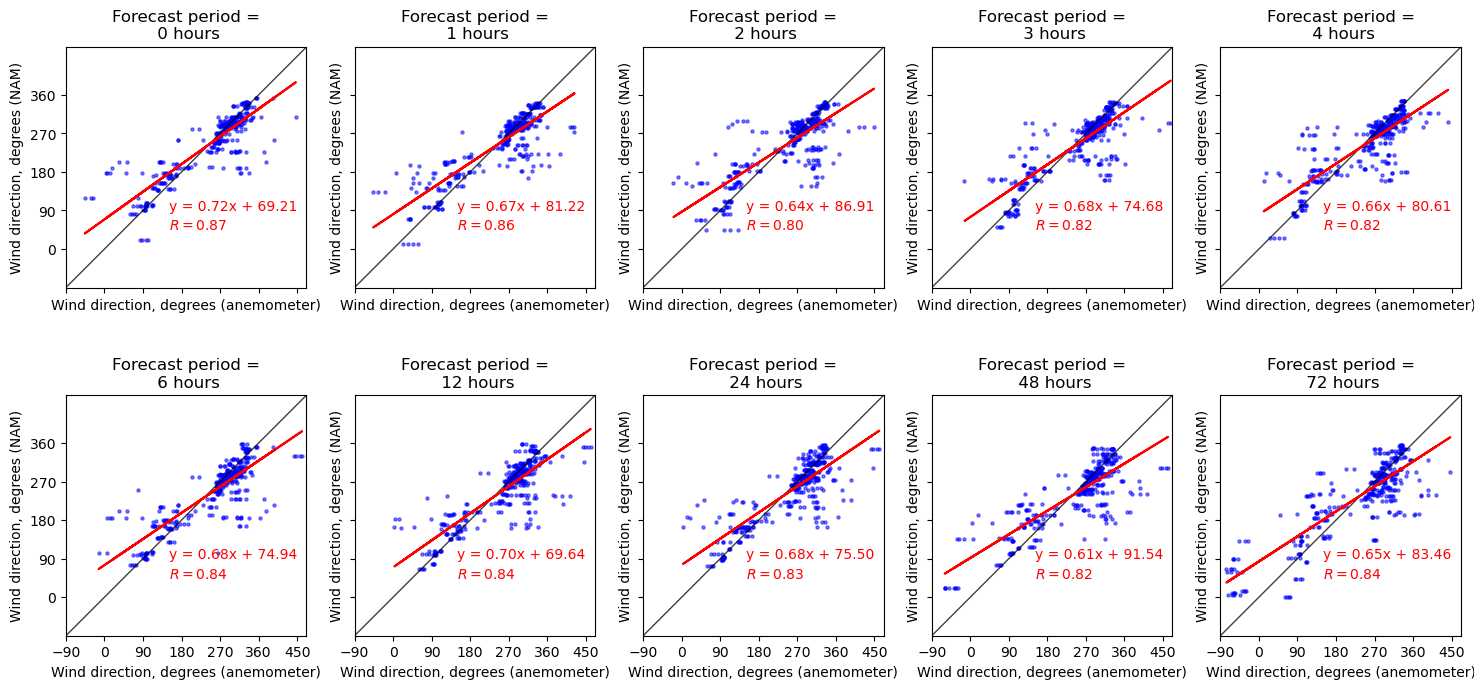

In [ ]:
# Scatterplot of wind direction nam vs 3d anemometer, trellised by forecast period 
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
# fig.tight_layout()
fig.subplots_adjust(hspace=.3)

for j, fp in enumerate(forcast_periods):
        row = j//5
        col = j%5
        ax = axes[row,col]
        subset3d = df_3d_and_nam[df_3d_and_nam['forecast_period']==fp]
        ax.scatter(subset3d['wdr_3d_corr'], subset3d['wdr_nam'], alpha=.5, lw=1, color="blue", label="3d", s=5)
        ax.set_title(f'Forecast period =\n {fp} hours')
        ax.set_xlabel('Wind direction, degrees (anemometer)')
        ax.set_ylabel('Wind direction, degrees (NAM)')
        ax.set_xticks([-90,0,90,180,270,360,450])
        ax.set_yticks([0,90,180,270,360])

        # plot line y=x
        lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=2, lw=1)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        # Find regression model using linregress in scripy.stats
        xdata = subset3d["wdr_3d_corr"]
        ydata = subset3d["wdr_nam"]
        mask = ~np.isnan(xdata) & ~np.isnan(ydata)
        slope, intercept, rvalue, pvalue, stderr = st.linregress(xdata[mask], ydata[mask])  # rvalue is the correlation coefficient, rvalue^2 is coefficeint of determination
        ylinreg = slope*xdata + intercept # regression values

        # plot regression model and correlation coefficient on scatterplot
        ax.plot(xdata, ylinreg, '-', color="red")
        ax.text(150,45,'$R = %0.2f$'% rvalue, fontsize = 10, color='red')
        ax.text(150,90,f'y = {slope:0.2f}x + {intercept:0.2f}', fontsize = 10, color='red')

plt.savefig("output/reg_wdr_nam.png", bbox_inches='tight')
plt.show()

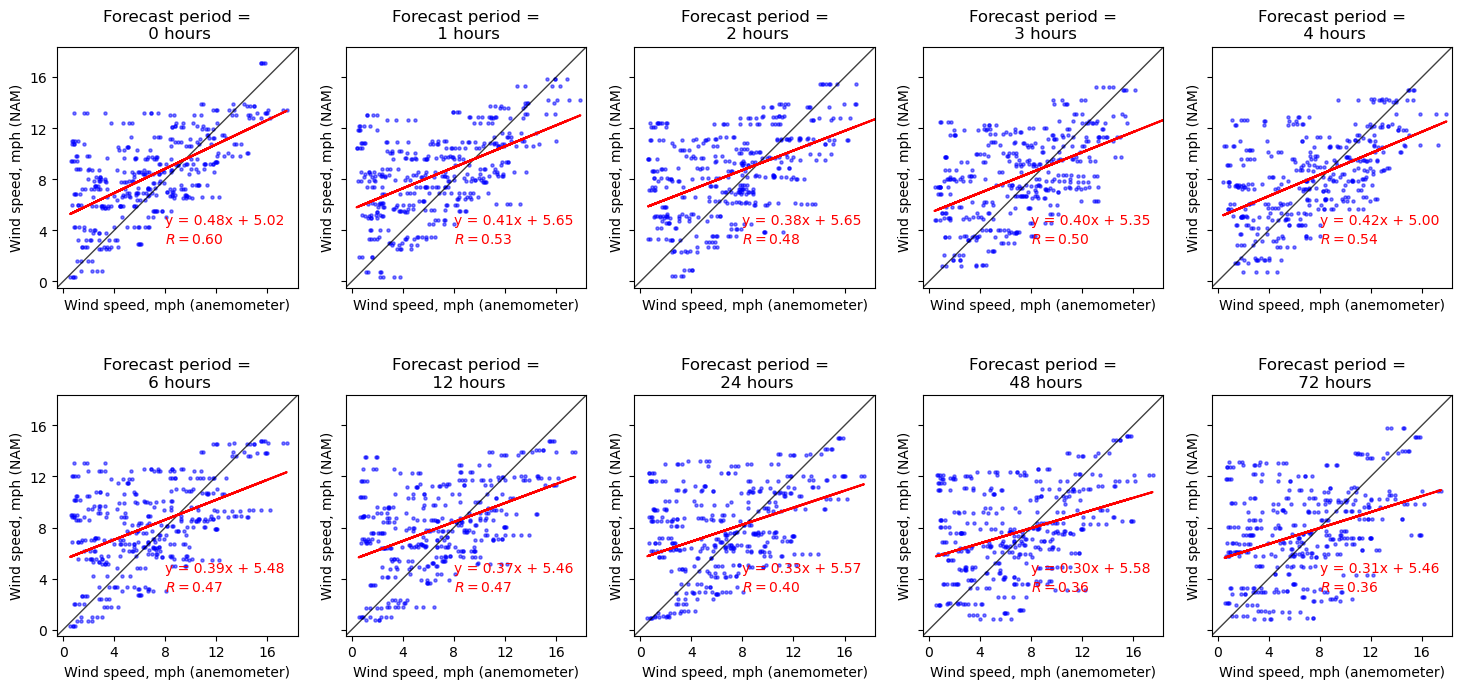

In [ ]:
# Scatterplot of wind speed nam vs 3d anemometer, trellised by forecast period 
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
# fig.tight_layout()
fig.subplots_adjust(hspace=.3)

for j, fp in enumerate(forcast_periods):
        row = j//5
        col = j%5
        ax = axes[row,col]
        subset3d = df_3d_and_nam[df_3d_and_nam['forecast_period']==fp]
        ax.scatter(subset3d['wspd_mph_3d'], subset3d['wspd_mph_nam'], alpha=.5, lw=1, color="blue", label="3d", s=5)
        ax.set_title(f'Forecast period =\n {fp} hours')
        ax.set_xlabel('Wind speed, mph (anemometer)')
        ax.set_ylabel('Wind speed, mph (NAM)')
        ax.set_xticks([0,4,8,12,16])
        ax.set_yticks([0,4,8,12,16])

        # plot line y=x
        lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=2, lw=1)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        # Find regression model using linregress in scripy.stats
        xdata = subset3d["wspd_mph_3d"]
        ydata = subset3d["wspd_mph_nam"]
        mask = ~np.isnan(xdata) & ~np.isnan(ydata)
        slope, intercept, rvalue, pvalue, stderr = st.linregress(xdata[mask], ydata[mask])  # rvalue is the correlation coefficient, rvalue^2 is coefficeint of determination
        ylinreg = slope*xdata + intercept # regression values

        # plot regression model and correlation coefficient on scatterplot
        ax.plot(xdata, ylinreg, '-', color="red")
        ax.text(8,3,'$R = %0.2f$'% rvalue, fontsize = 10, color='red')
        ax.text(8,4.5,f'y = {slope:0.2f}x + {intercept:0.2f}', fontsize = 10, color='red')

plt.savefig("output/reg_wspd_nam.png", bbox_inches='tight')
plt.show()

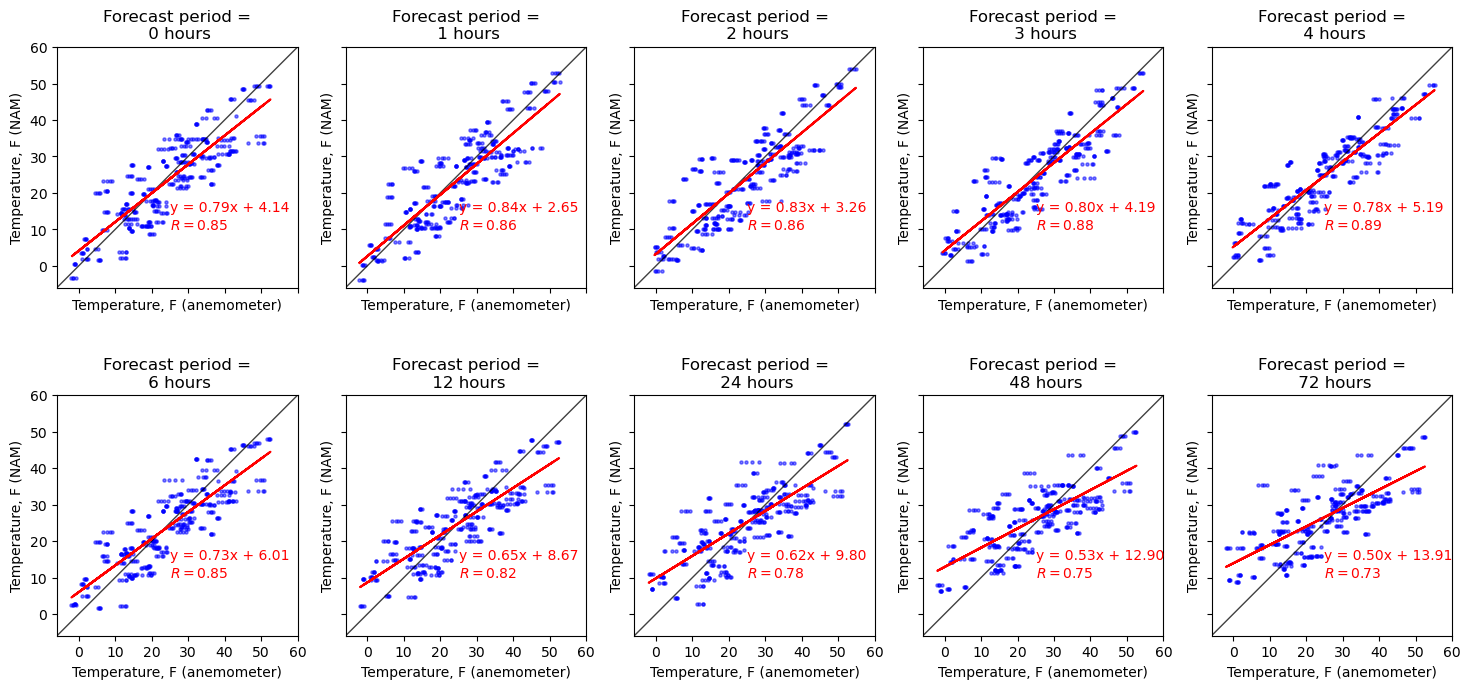

In [ ]:
# Scatterplot of temperature nam vs 3d anemometer, trellised by forecast period 
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
# fig.tight_layout()
fig.subplots_adjust(hspace=.3)

for j, fp in enumerate(forcast_periods):
        row = j//5
        col = j%5
        ax = axes[row,col]
        subset3d = df_3d_and_nam[df_3d_and_nam['forecast_period']==fp]
        ax.scatter(subset3d['temp_F_3d'], subset3d['temp_F_nam'], alpha=.5, lw=1, color="blue", label="3d", s=5)
        ax.set_title(f'Forecast period =\n {fp} hours')
        ax.set_xlabel('Temperature, F (anemometer)')
        ax.set_ylabel('Temperature, F (NAM)')
        ax.set_xticks([0,10,20,30,40,50,60])
        ax.set_xticks([0,10,20,30,40,50,60])

        # plot line y=x
        lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=2, lw=1)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        # Find regression model using linregress in scripy.stats
        xdata = subset3d["temp_F_3d"]
        ydata = subset3d["temp_F_nam"]
        mask = ~np.isnan(xdata) & ~np.isnan(ydata)
        slope, intercept, rvalue, pvalue, stderr = st.linregress(xdata[mask], ydata[mask])  # rvalue is the correlation coefficient, rvalue^2 is coefficeint of determination
        ylinreg = slope*xdata + intercept # regression values

        # plot regression model and correlation coefficient on scatterplot
        ax.plot(xdata, ylinreg, '-', color="red")
        ax.text(25,10,'$R = %0.2f$'% rvalue, fontsize = 10, color='red')
        ax.text(25,15,f'y = {slope:0.2f}x + {intercept:0.2f}', fontsize = 10, color='red')

plt.savefig("output/reg_temp_nam.png", bbox_inches='tight')
plt.show()

### Scatterplots NAM - 3d vs. kinetic energy, trellised by forecast period

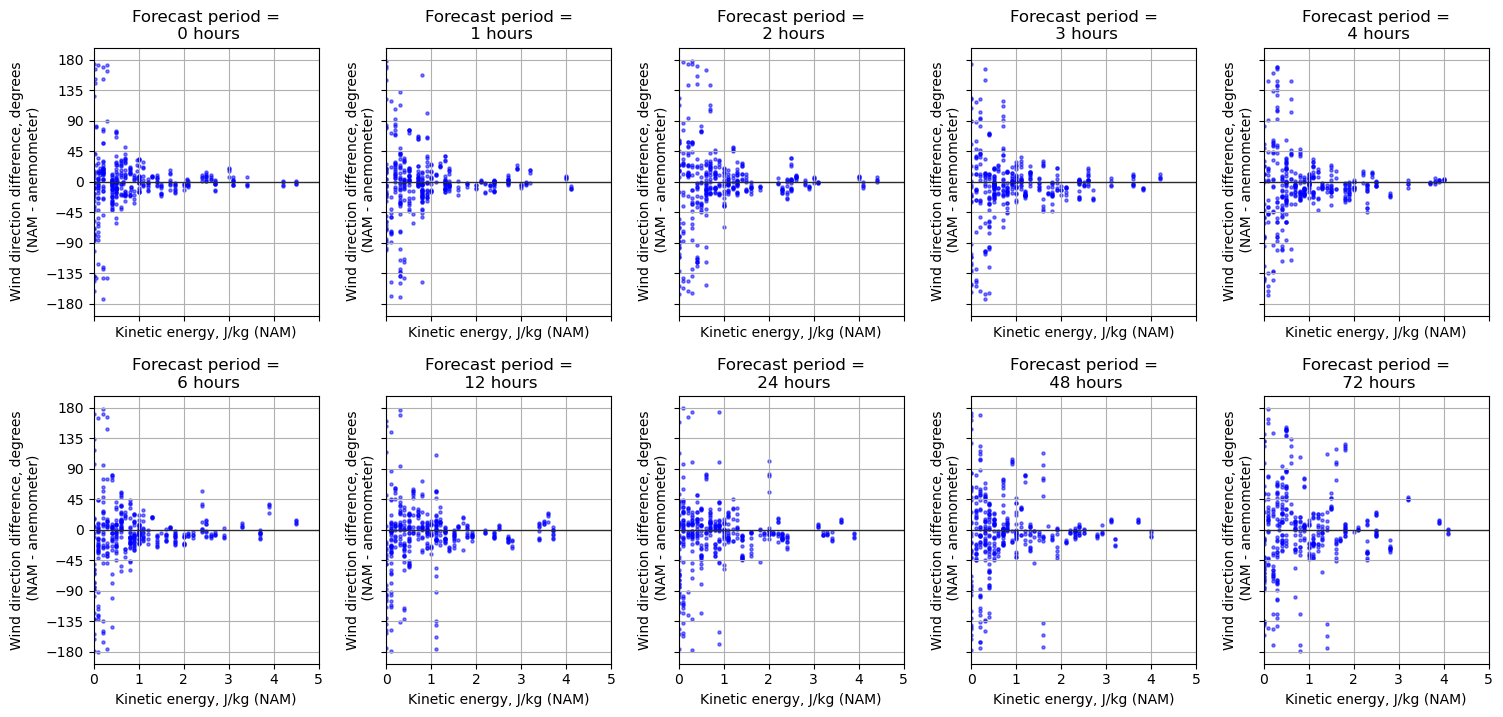

In [ ]:
# Scatterplot of wind direction diff nam - 3d vs kinetic energy, trellised by forecast period
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
# fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)

for j, fp in enumerate(forcast_periods):
        row = j//5
        col = j%5
        ax = axes[row,col]
        subset = df_3d_and_nam[df_3d_and_nam['forecast_period']==fp]
        ax.scatter(subset['kinetic_e'], subset['wdr_diff'], alpha=.5, lw=1, color="blue",label="3d", s=5)
        ax.set_title(f'Forecast period =\n {fp} hours')
        ax.set_xlim([0,5])
        ax.set_xlabel('Kinetic energy, J/kg (NAM)')
        ax.set_ylabel('Wind direction difference, degrees\n (NAM - anemometer)')
        ax.grid(True) 
        ax.set_xticks([0,1,2,3,4,5])
        ax.set_yticks([-180,-135,-90,-45,0,45,90,135,180])
        
        # plot line y=0
        ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)

plt.savefig("output/scatter_wdr_diff_per_ke_nam.png", bbox_inches='tight')
plt.show()


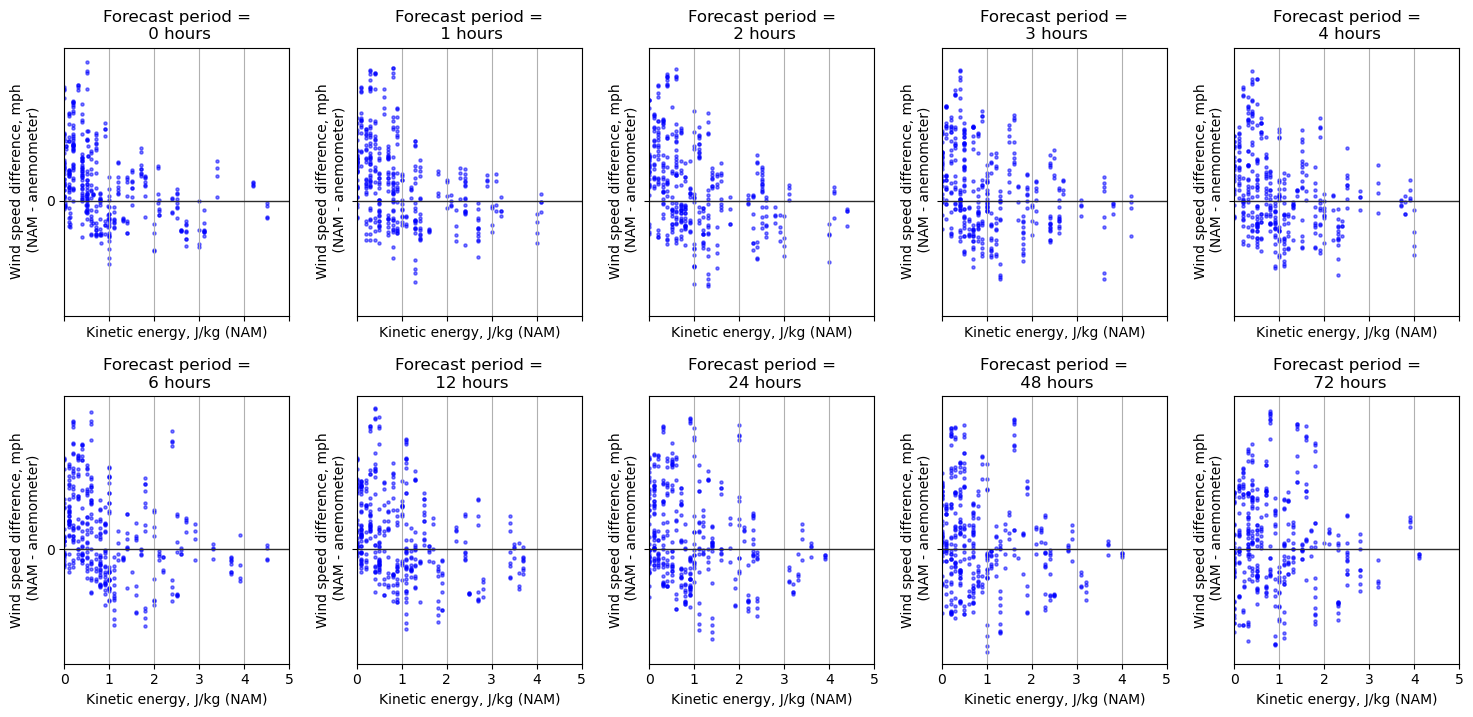

In [ ]:
# Scatterplot of wind speed diff nam - 3d vs kinetic energy, trellised by forecast period
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
# fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)

for j, fp in enumerate(forcast_periods):
        row = j//5
        col = j%5
        ax = axes[row,col]
        subset = df_3d_and_nam[df_3d_and_nam['forecast_period']==fp]
        ax.scatter(subset['kinetic_e'], subset['wspd_mph_diff'], alpha=.5, lw=1, color="blue",label="3d", s=5)
        ax.set_title(f'Forecast period =\n {fp} hours')
        ax.set_xlim([0,5])
        ax.set_xlabel('Kinetic energy, J/kg (NAM)')
        ax.set_ylabel('Wind speed difference, mph\n (NAM - anemometer)')
        ax.grid(True) 
        ax.set_xticks([0,1,2,3,4,5])
        ax.set_yticks([-180,-135,-90,-45,0,45,90,135,180])
        
        # plot line y=0
        ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)

plt.savefig("output/scatter_wspd_diff_per_ke_nam.png", bbox_inches='tight')
plt.show()


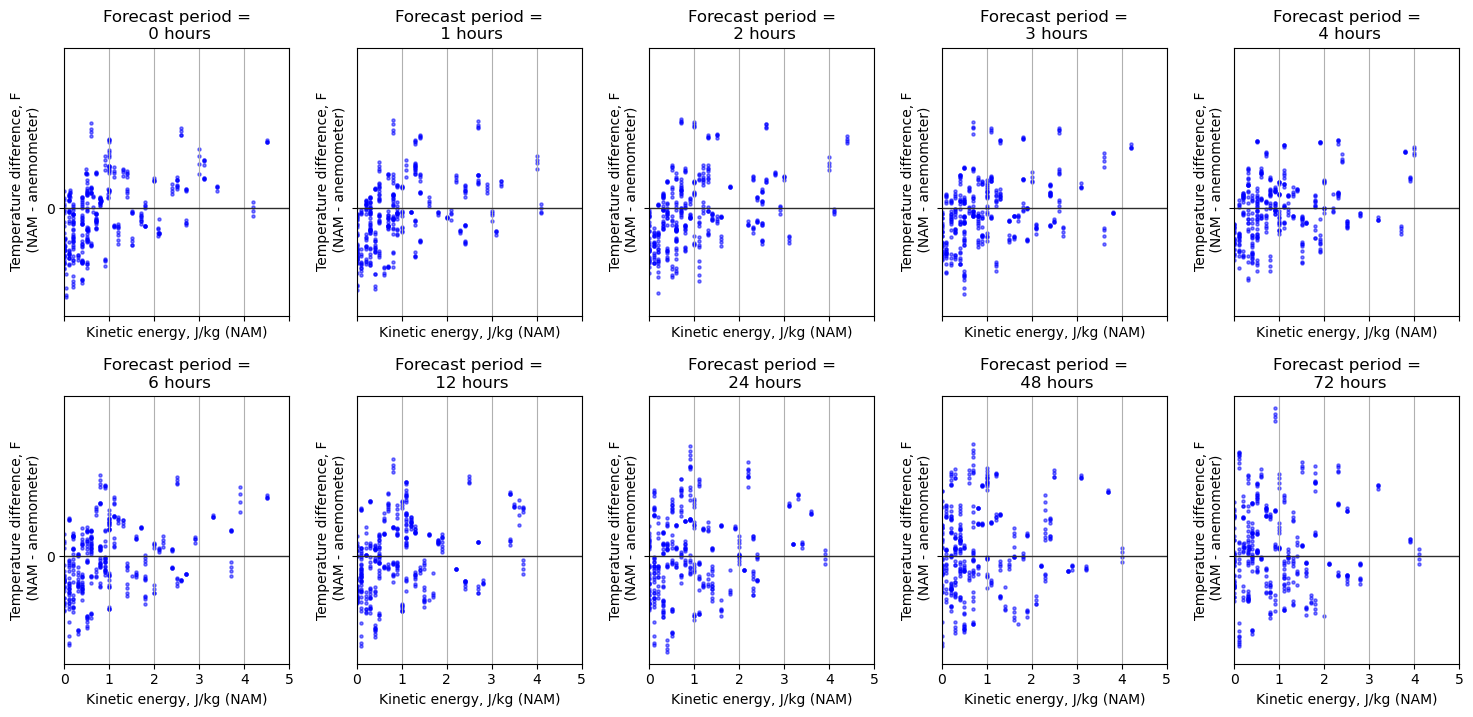

In [ ]:
# Scatterplot of wind speed diff nam - 3d vs kinetic energy, trellised by forecast period
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
# fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)

for j, fp in enumerate(forcast_periods):
        row = j//5
        col = j%5
        ax = axes[row,col]
        subset = df_3d_and_nam[df_3d_and_nam['forecast_period']==fp]
        ax.scatter(subset['kinetic_e'], subset['temp_F_diff'], alpha=.5, lw=1, color="blue",label="3d", s=5)
        ax.set_title(f'Forecast period =\n {fp} hours')
        ax.set_xlim([0,5])
        ax.set_xlabel('Kinetic energy, J/kg (NAM)')
        ax.set_ylabel('Temperature difference, F\n (NAM - anemometer)')
        ax.grid(True) 
        ax.set_xticks([0,1,2,3,4,5])
        ax.set_yticks([-180,-135,-90,-45,0,45,90,135,180])
        
        # plot line y=0
        ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)

plt.savefig("output/scatter_temp_diff_per_ke_nam.png", bbox_inches='tight')
plt.show()


### Wind elevation

In [104]:
# Define a custom colormap with smooth transitions between colors
colors = ["darkgreen", "pink", "crimson","crimson"]  
cmap = LinearSegmentedColormap.from_list("pink_yellow_green", colors)

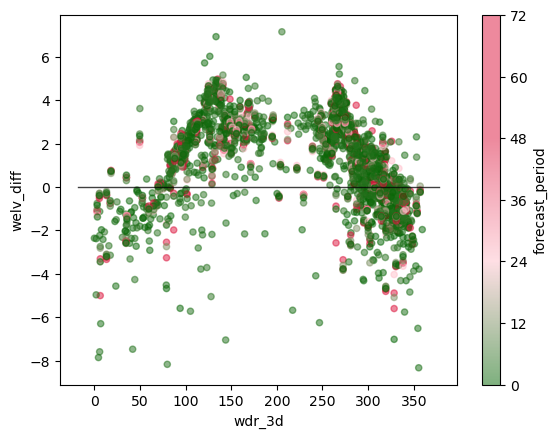

In [105]:
# Scatterplot of wind elev diff nam - 3d vs wind direction
ax = df_3d_and_nam.plot.scatter(x='wdr_3d',y='welv_diff', c='forecast_period', cmap=cmap, alpha=.5)
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)

# set colorbar ticks
f = plt.gcf()
cax = f.get_axes()[1]
# cax.set_ylabel('forecast period')
cax.set_yticks([0,12,24,36,48,60,72])
cax.set_yticklabels([0,12,24,36,48,60,72])

plt.show()

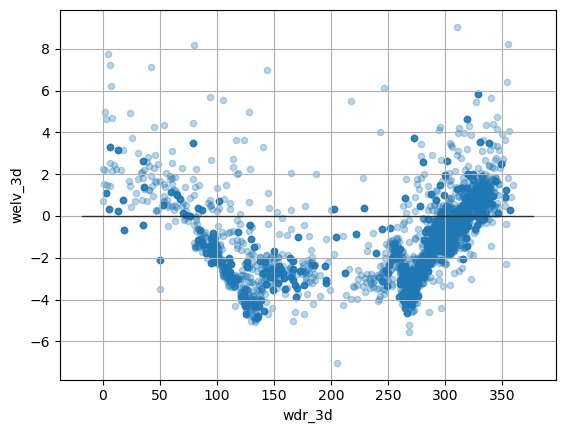

In [106]:
# Scatterplot of wind elev with wind dir for 3d anemometer
ax = df_3d_and_nam.plot.scatter(x='wdr_3d',y='welv_3d', alpha=.3)
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.grid(True) 

plt.savefig("output/scatter_welv_vs_wdr_anemometer.png", bbox_inches='tight')
plt.show()

### Timeseries of 3d anemometer measurements and NAM forecasts

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


Average temperature diff NAM-3d: -1.0108819019385324 F
Average wind direction diff NAM-3d: -1.7109153500802365 degrees
Average wind speed diff NAM-3d: 1.4297886317454587 mph


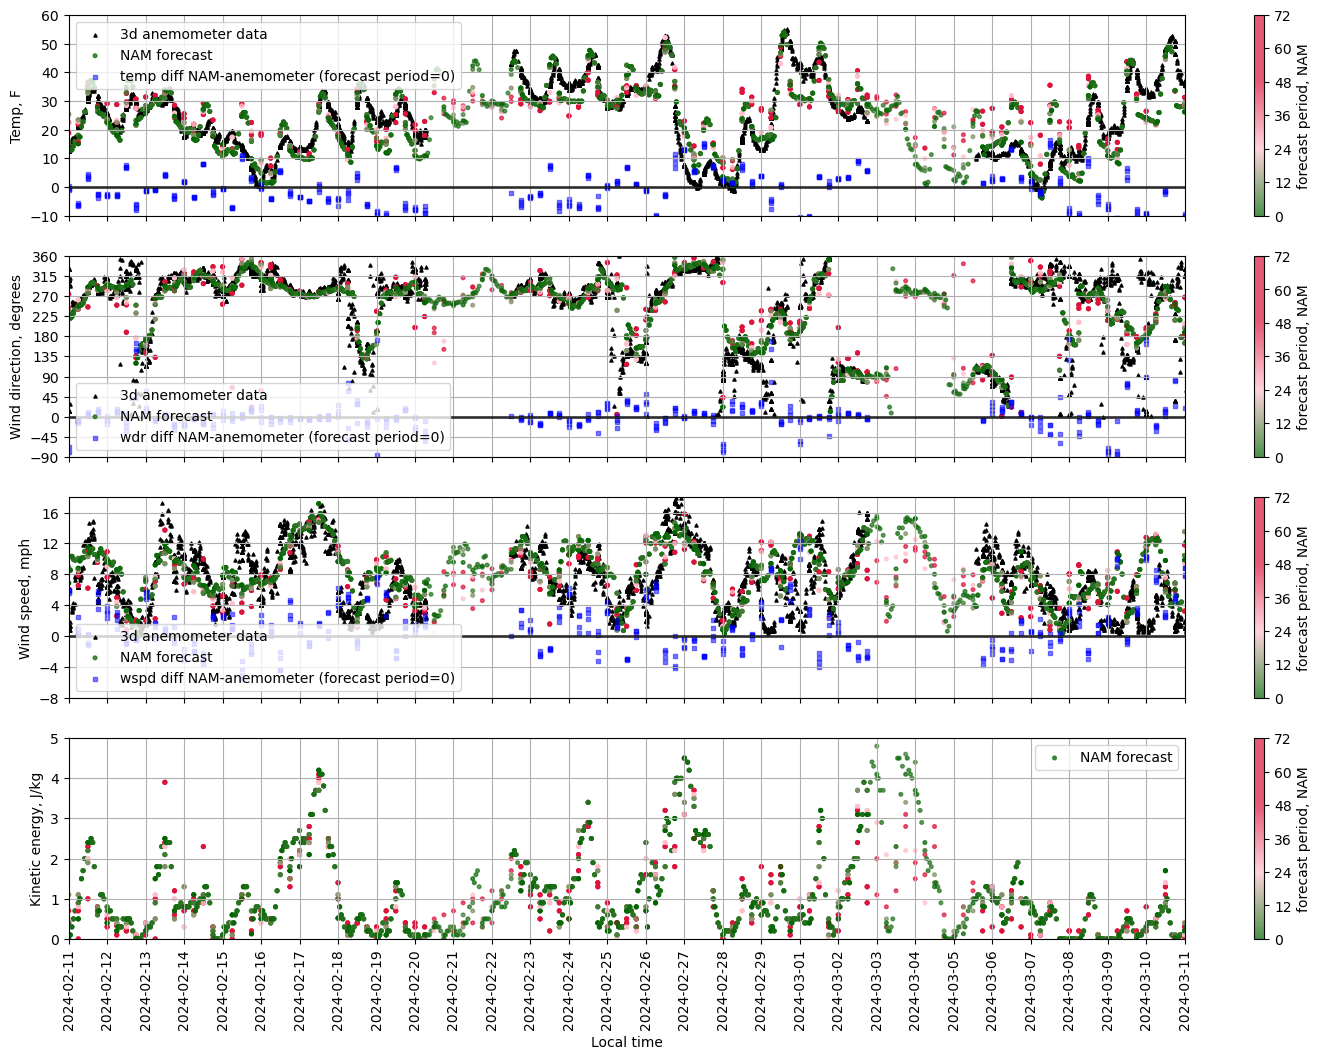

In [ ]:
# Timeseries of 3d anemometer measurements and NAM forecasts

fullset = df_3d_and_nam
subset = df_3d_and_nam[df_3d_and_nam['forecast_period']==0]

# Create a list of dates, 2024-02-11 to 2024-03-11
start_date = datetime(2024, 2, 11)
end_date = datetime(2024, 3, 11)
dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end_date - start_date).days + 1)]

fig, axes = plt.subplots(4,1, figsize=(18,12), sharex=True)

ax = axes[0] 
ax.scatter(pd.to_datetime(fullset['date_forecasted']) + pd.to_timedelta(fullset['hour_forecasted'], unit='h'), 
                fullset[f'temp_F_3d'], alpha=1, c='black', s=5, marker='^', label=f'3d anemometer data')
p = ax.scatter(pd.to_datetime(fullset['date_forecasted']) + pd.to_timedelta(fullset['hour_forecasted'], unit='h'), 
                fullset['temp_F_nam'], alpha=0.7, c=fullset['forecast_period'], cmap=cmap, s=7, marker='o', label='NAM forecast')
ax.scatter(pd.to_datetime(subset['date_forecasted']) + pd.to_timedelta(subset['hour_forecasted'], unit='h'), 
                subset['temp_F_diff'], alpha=.5, c='blue', s=5, marker='s', label='temp diff NAM-anemometer (forecast period=0)')
ax.legend()
ax.set_ylim([-10,60])
ax.set_yticks([-10,0,10,20,30,40,50,60])
ax.grid(True) 
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=2) 
# ax.set_xlabel('Local time')
ax.set_ylabel('Temp, F')
plt.colorbar(p, ticks=[0,12,24,36,48,60,72], label="forecast period, NAM")

ax = axes[1] 
ax.scatter(pd.to_datetime(fullset['date_forecasted']) + pd.to_timedelta(fullset['hour_forecasted'], unit='h'), 
                fullset[f'wdr_3d'], alpha=1, c='black', s=5, marker='^', label=f'3d anemometer data')
p = ax.scatter(pd.to_datetime(fullset['date_forecasted']) + pd.to_timedelta(fullset['hour_forecasted'], unit='h'), 
                fullset['wdr_nam'], alpha=0.7, c=fullset['forecast_period'], cmap=cmap, s=7, marker='o', label='NAM forecast')
ax.scatter(pd.to_datetime(subset['date_forecasted']) + pd.to_timedelta(subset['hour_forecasted'], unit='h'), 
                subset['wdr_diff'], alpha=.5, c='blue', s=5, marker='s', label='wdr diff NAM-anemometer (forecast period=0)')
ax.legend()
ax.set_ylim([-90,360])
ax.set_yticks([-90,-45,0,45,90,135,180,225,270,315,360])
ax.grid(True) 
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=2) 
# ax.set_xlabel('Local time')
ax.set_ylabel('Wind direction, degrees')
plt.colorbar(p, ticks=[0,12,24,36,48,60,72], label="forecast period, NAM")

ax = axes[2] 
ax.scatter(pd.to_datetime(fullset['date_forecasted']) + pd.to_timedelta(fullset['hour_forecasted'], unit='h'), 
                fullset[f'wspd_mph_3d'], alpha=1, c='black',  s=5, marker='^', label=f'3d anemometer data')
p = ax.scatter(pd.to_datetime(fullset['date_forecasted']) + pd.to_timedelta(fullset['hour_forecasted'], unit='h'), 
                fullset['wspd_mph_nam'], alpha=0.7, c=fullset['forecast_period'], cmap=cmap, s=7, marker='o', label='NAM forecast')
ax.scatter(pd.to_datetime(subset['date_forecasted']) + pd.to_timedelta(subset['hour_forecasted'], unit='h'), 
                subset['wspd_mph_diff'], alpha=.5, c='blue', s=5, marker='s', label='wspd diff NAM-anemometer (forecast period=0)')
ax.legend()
ax.set_ylim([-8,18])
ax.set_yticks([-8,-4,0,4,8,12,16])
ax.grid(True) 
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=2) 
# ax.set_xlabel('Local time')
ax.set_ylabel('Wind speed, mph')
plt.colorbar(p, ticks=[0,12,24,36,48,60,72], label="forecast period, NAM")

ax = axes[3] 
p = ax.scatter(pd.to_datetime(fullset['date_forecasted']) + pd.to_timedelta(fullset['hour_forecasted'], unit='h'), 
                fullset['kinetic_e'], alpha=0.7, c=fullset['forecast_period'], cmap=cmap, s=7, marker='o', label='NAM forecast')
ax.legend()
ax.set_ylim([0,5])
ax.set_yticks([0,1,2,3,4,5])
ax.grid(True) 
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])
ax.set_xticks(dates)
ax.set_xlabel('Local time')
ax.set_ylabel('Kinetic energy, J/kg')
plt.colorbar(p, ticks=[0,12,24,36,48,60,72], label="forecast period, NAM")
plt.xticks(rotation=90)

print(f"Average temperature diff NAM-3d: {subset['temp_F_diff'].mean()} F")
print(f"Average wind direction diff NAM-3d: {subset['wdr_diff'].mean()} degrees")
print(f"Average wind speed diff NAM-3d: {subset['wspd_mph_diff'].mean()} mph")

plt.savefig(f"output/nam_and_3d_timeseries_all.png", bbox_inches='tight')

### More NAM Forecast Timeseries

In [108]:
# Create a list of dates, 2024-02-11 to 2024-03-11
start_date = datetime(2024, 2, 11)
end_date = datetime(2024, 3, 11)
dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end_date - start_date).days + 1)]

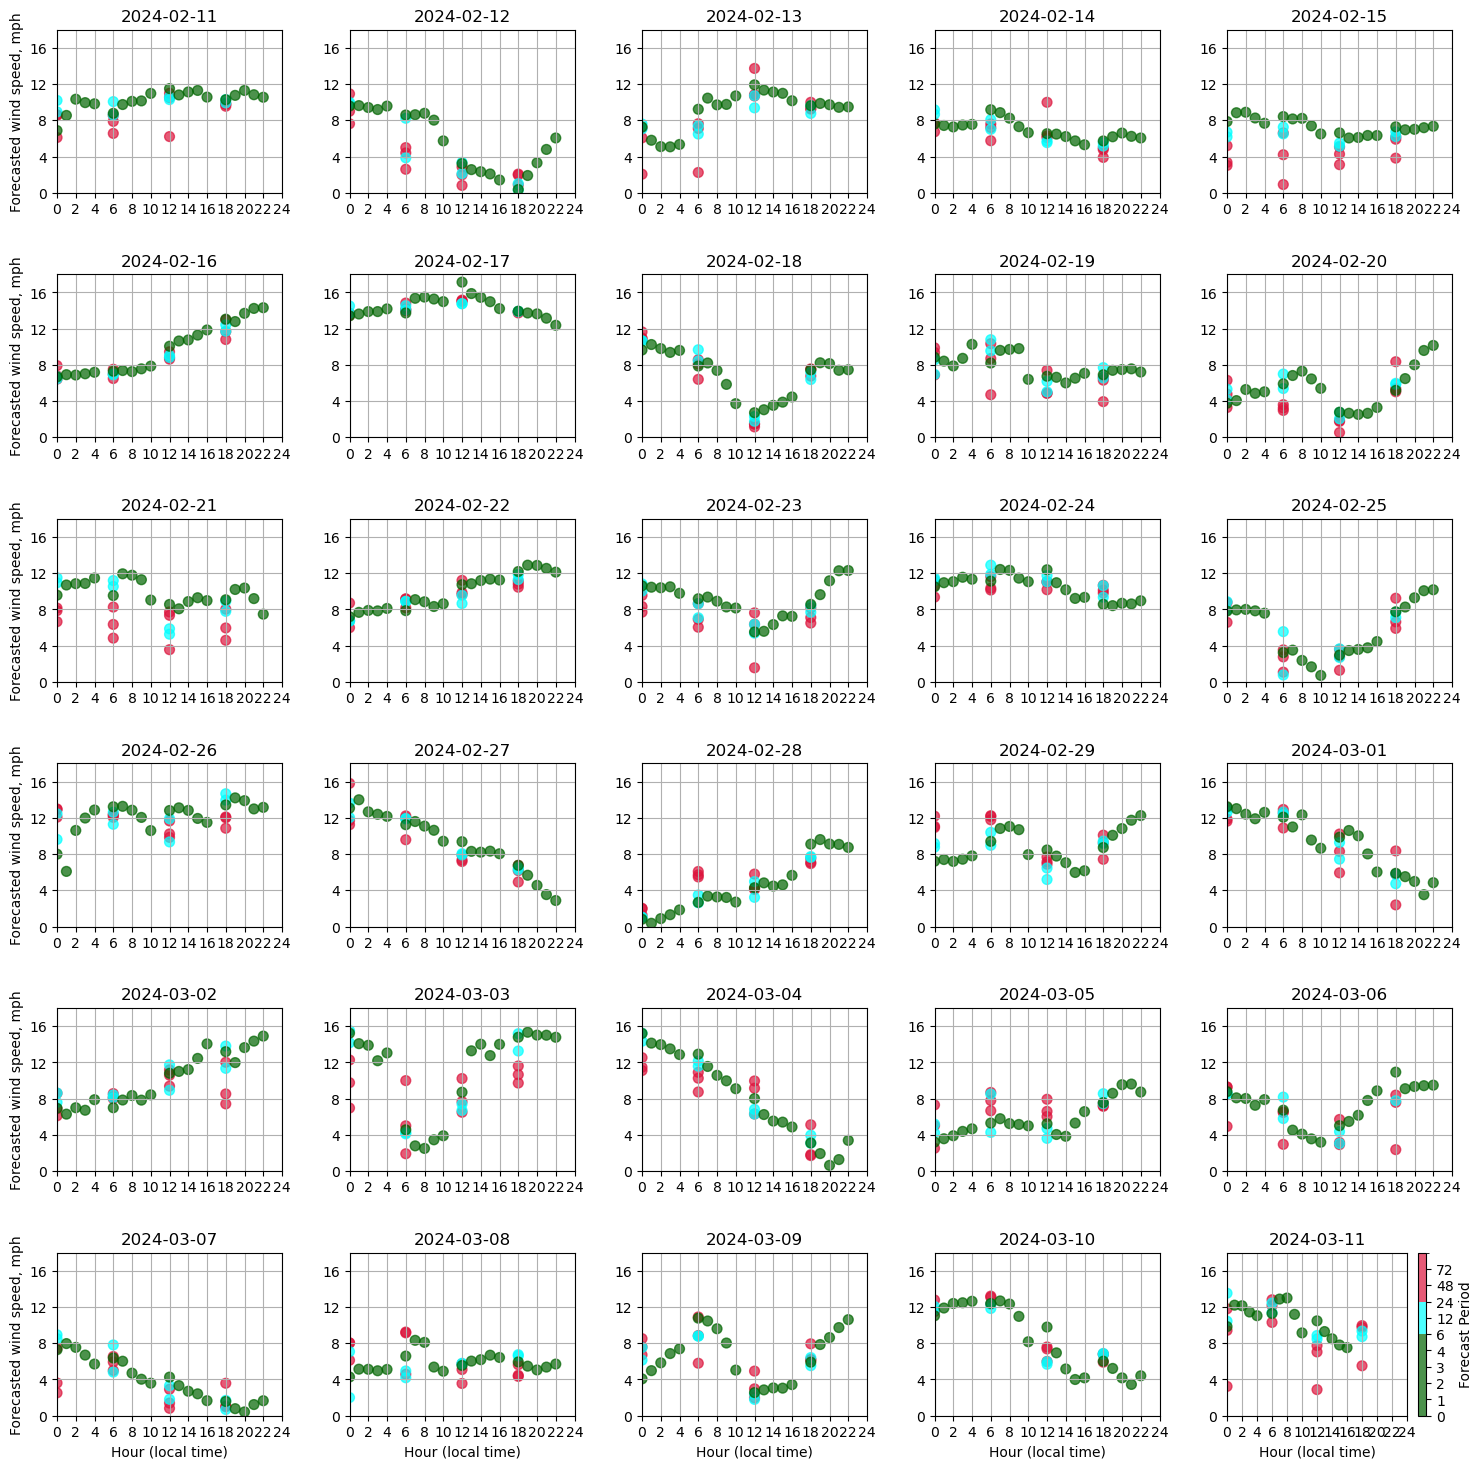

In [109]:
# Define a custom colormap with smooth transitions between colors
#colors = ["darkgreen", "pink", "crimson","crimson"]  
#cmap = LinearSegmentedColormap.from_list("pink_yellow_green", colors)

from matplotlib.colors import ListedColormap, BoundaryNorm
colors = ['darkgreen', 'darkgreen', 'darkgreen', 'darkgreen', 'darkgreen', 'cyan','cyan','crimson','crimson','crimson']  # Define as many colors as you have forecast periods
cmap = ListedColormap(colors)
# Map each unique forecast_period to a color
forecast_periods = data_nam['forecast_period'].unique()
bounds = np.append(forecast_periods, forecast_periods[-1]+1)  # Extend one more boundary to cover last period
norm = BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(6,5, figsize=(18,18))
#fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)

for j, category in enumerate(dates):
        subset = data_nam[data_nam['date_forecasted']==dates[j]]
        row = j//5
        col = j%5
        ax = axes[row,col] 
        p = ax.scatter(subset['hour_forecasted'], subset['wspd_mph'], alpha=0.7, c=subset['forecast_period'], cmap=cmap, norm=norm, s=50)
        ax.set_title(pd.to_datetime(dates[j]).date())
        ax.set_xlim([0,24])
        ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
        ax.set_ylim([0,18])
        ax.set_yticks([0,4,8,12,16])
        ax.grid(True) 
        if row==5:
                ax.set_xlabel('Hour (local time)')
        if col==0:
                ax.set_ylabel('Forecasted wind speed, mph')
cbar = plt.colorbar(p, ax=ax, boundaries=bounds, ticks=forecast_periods)
cbar.set_label('Forecast Period')

plt.savefig("output/nam_timeseries_wspd.png", bbox_inches='tight')

plt.show()


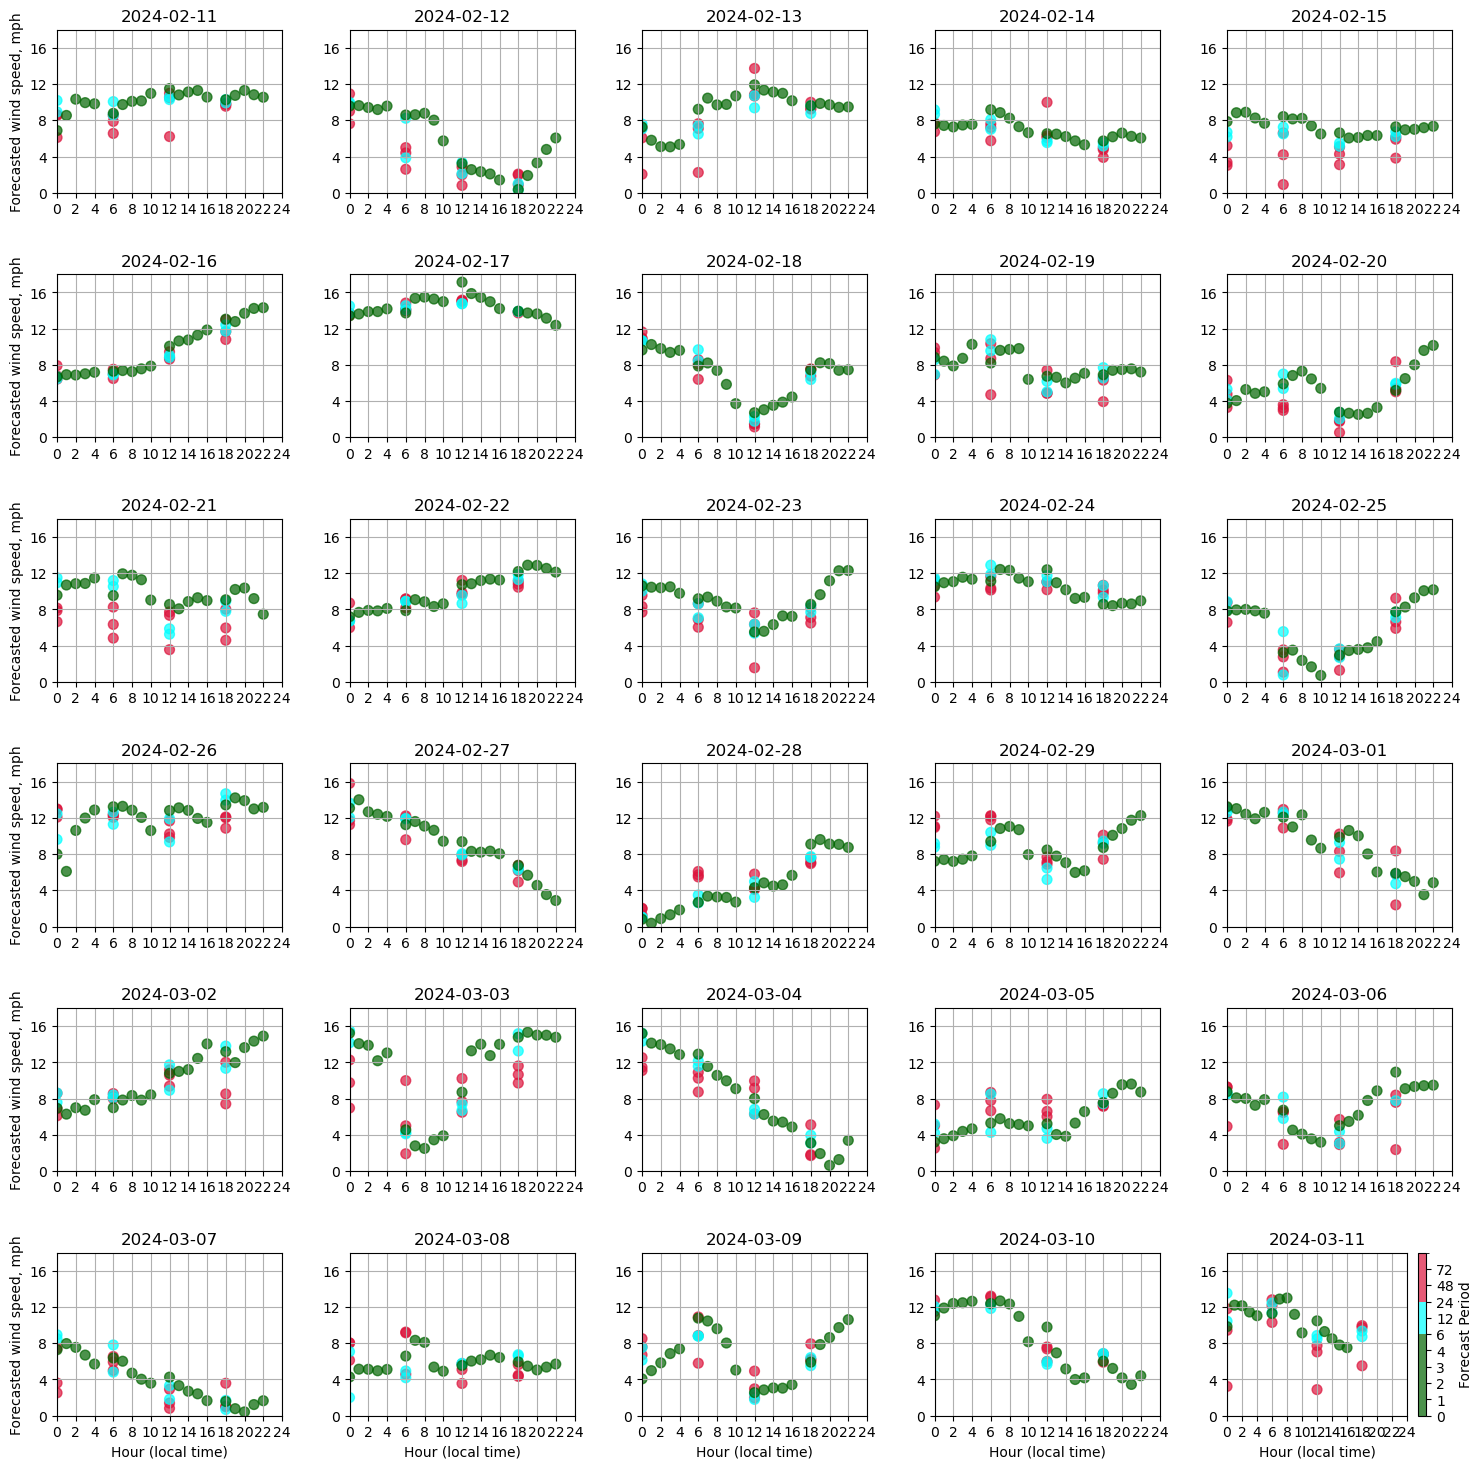

In [110]:
fig, axes = plt.subplots(6,5, figsize=(18,18))
#fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)

for j, category in enumerate(dates):
        subset = data_nam[data_nam['date_forecasted']==dates[j]]
        row = j//5
        col = j%5
        ax = axes[row,col] 
        p = ax.scatter(subset['hour_forecasted'], subset['wspd_mph'], alpha=0.7, c=subset['forecast_period'], cmap=cmap, norm=norm, s=50)
        ax.set_title(pd.to_datetime(dates[j]).date())
        ax.set_xlim([0,24])
        ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
        ax.set_ylim([0,18])
        ax.set_yticks([0,4,8,12,16])
        ax.grid(True) 
        if row==5:
                ax.set_xlabel('Hour (local time)')
        if col==0:
                ax.set_ylabel('Forecasted wind speed, mph')
cbar = plt.colorbar(p, ax=ax, boundaries=bounds, ticks=forecast_periods)
cbar.set_label('Forecast Period')

plt.savefig("output/nam_timeseries_wspd.png", bbox_inches='tight')

plt.show()


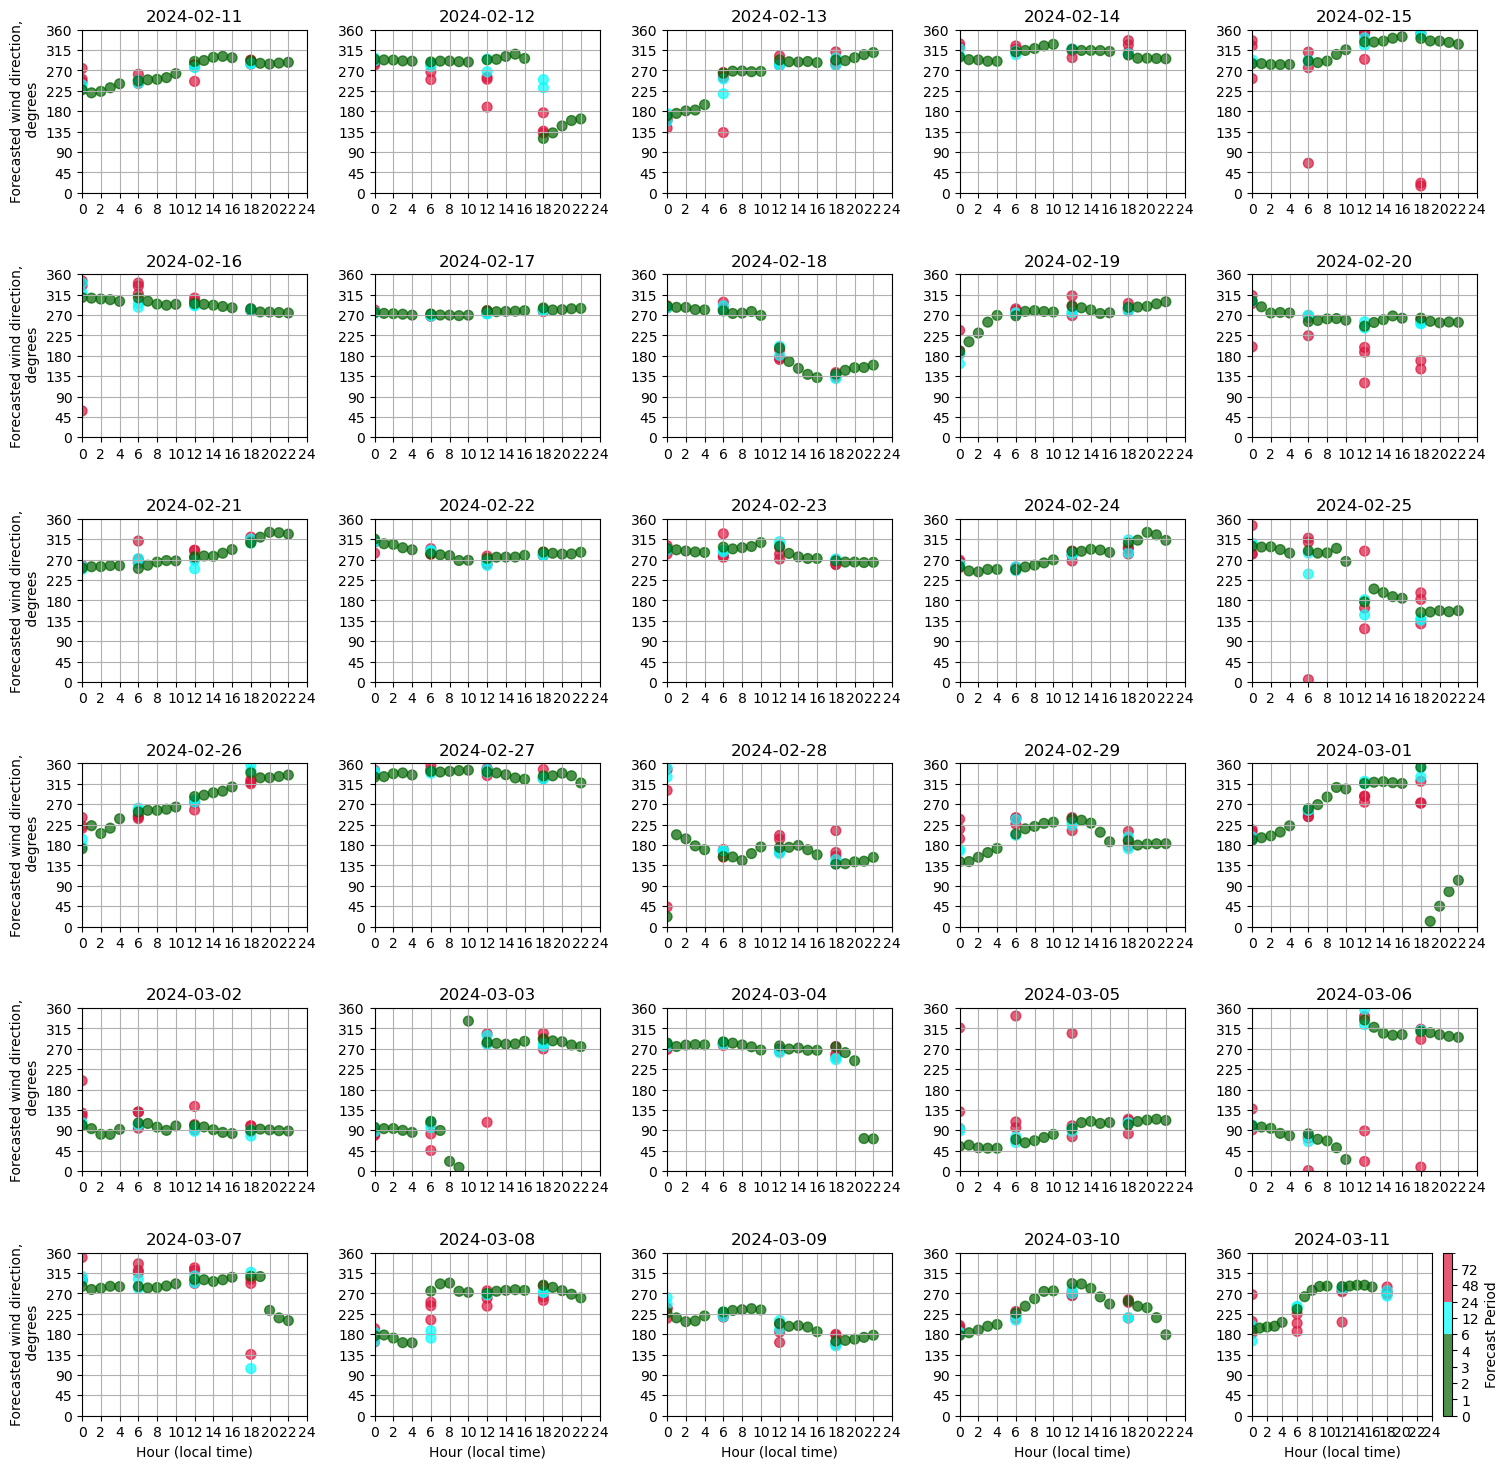

In [111]:
fig, axes = plt.subplots(6,5, figsize=(18,18))
#fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)

for j, category in enumerate(dates):
        subset = data_nam[data_nam['date_forecasted']==dates[j]]
        row = j//5
        col = j%5
        ax = axes[row,col] 
        p = ax.scatter(subset['hour_forecasted'], subset['wdr'], alpha=0.7, c=subset['forecast_period'], cmap=cmap, norm=norm, s=50)
        ax.set_title(pd.to_datetime(dates[j]).date())
        ax.set_xlim([0,24])
        ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
        ax.set_ylim([0,360])
        ax.set_yticks([0,45,90,135,180,225,270,315,360])
        ax.grid(True) 
        if row==5:
                ax.set_xlabel('Hour (local time)')
        if col==0:
                ax.set_ylabel('Forecasted wind direction,\n degrees')
cbar = plt.colorbar(p, ax=ax, boundaries=bounds, ticks=forecast_periods)
cbar.set_label('Forecast Period')

plt.savefig("output/nam_timeseries_wdr.png", bbox_inches='tight')

plt.show()


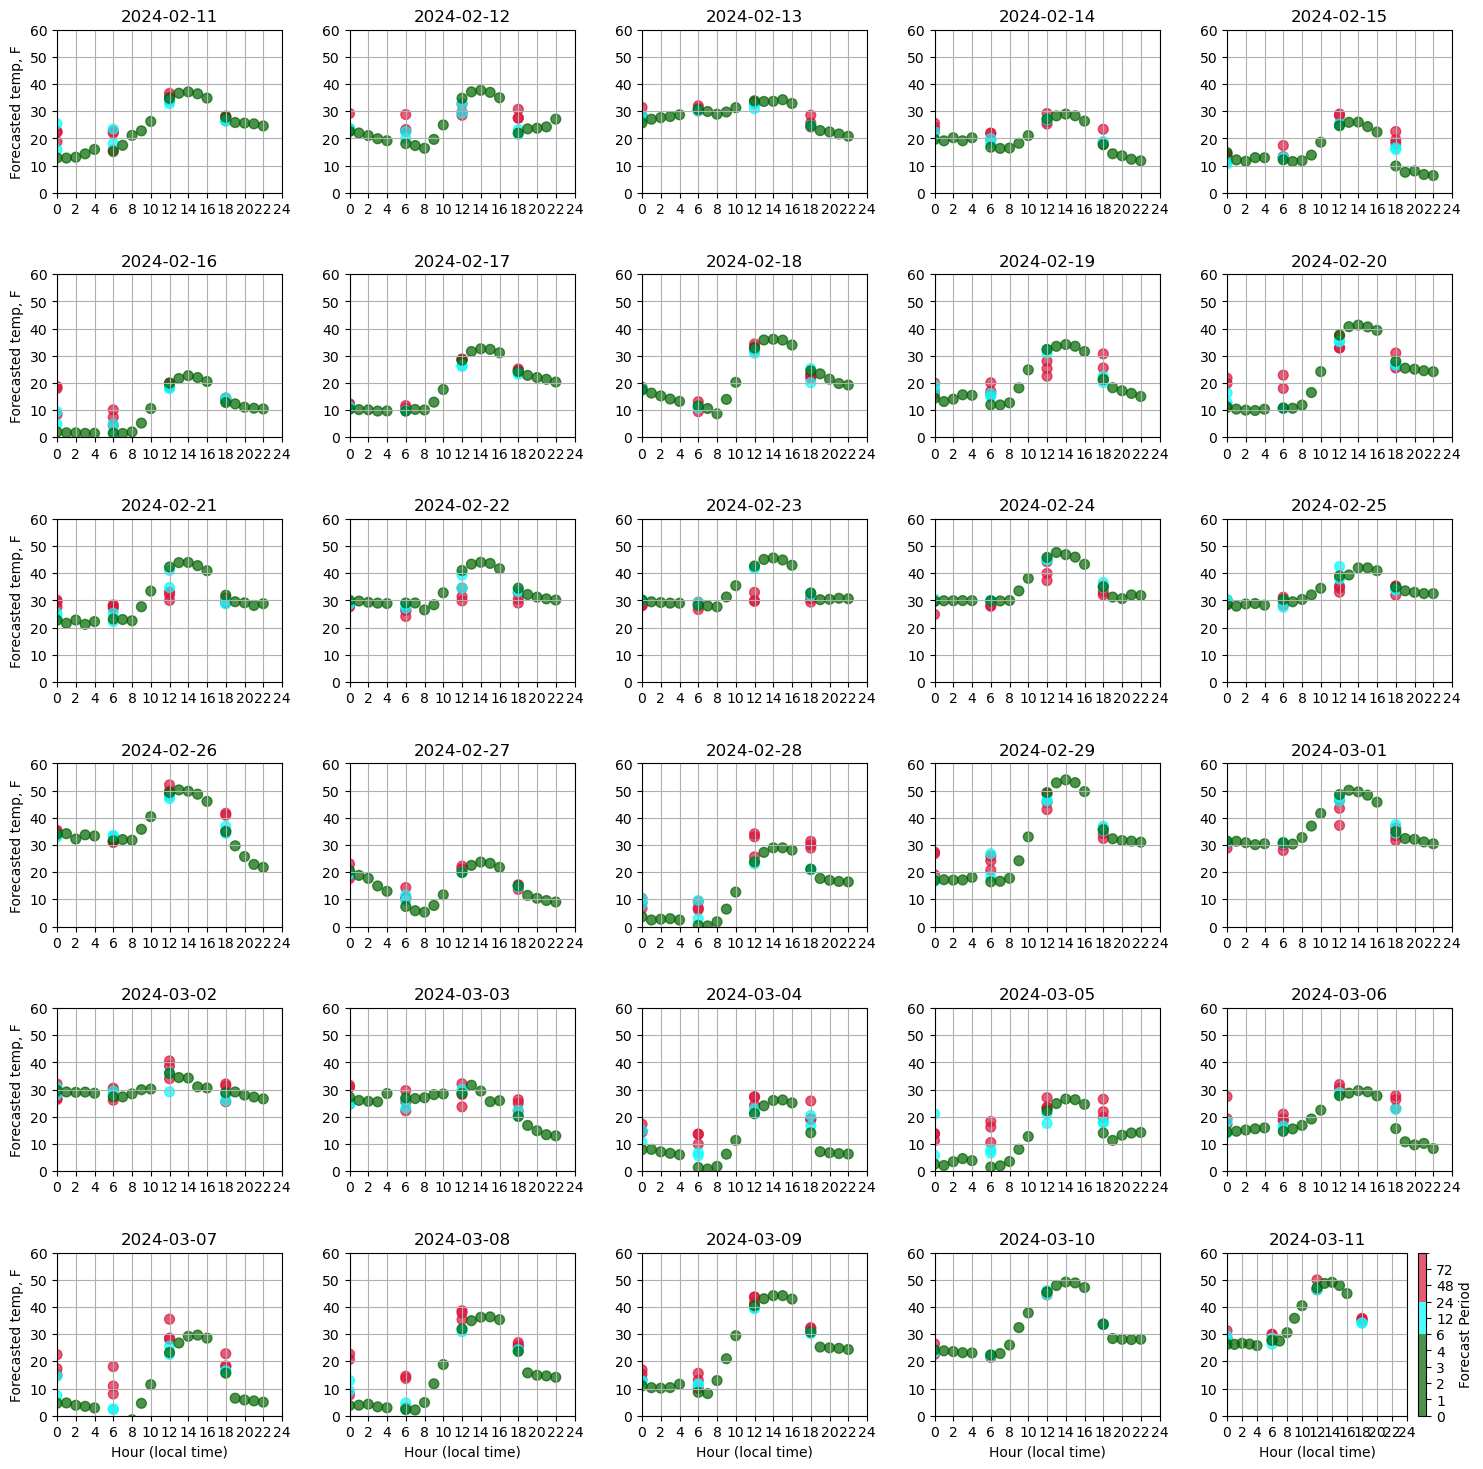

In [112]:
fig, axes = plt.subplots(6,5, figsize=(18,18))
#fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)

for j, category in enumerate(dates):
        subset = data_nam[data_nam['date_forecasted']==dates[j]]
        row = j//5
        col = j%5
        ax = axes[row,col] 
        p = ax.scatter(subset['hour_forecasted'], subset['temp_F'], alpha=0.7, c=subset['forecast_period'], cmap=cmap, norm=norm, s=50)
        ax.set_title(pd.to_datetime(dates[j]).date())
        ax.set_xlim([0,24])
        ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
        ax.set_ylim([0,60])
        ax.set_yticks([0,10,20,30,40,50,60])
        ax.grid(True) 
        if row==5:
                ax.set_xlabel('Hour (local time)')
        if col==0:
                ax.set_ylabel('Forecasted temp, F')
cbar = plt.colorbar(p, ax=ax, boundaries=bounds, ticks=forecast_periods)
cbar.set_label('Forecast Period')

plt.savefig("output/nam_timeseries_temp.png", bbox_inches='tight')

plt.show()


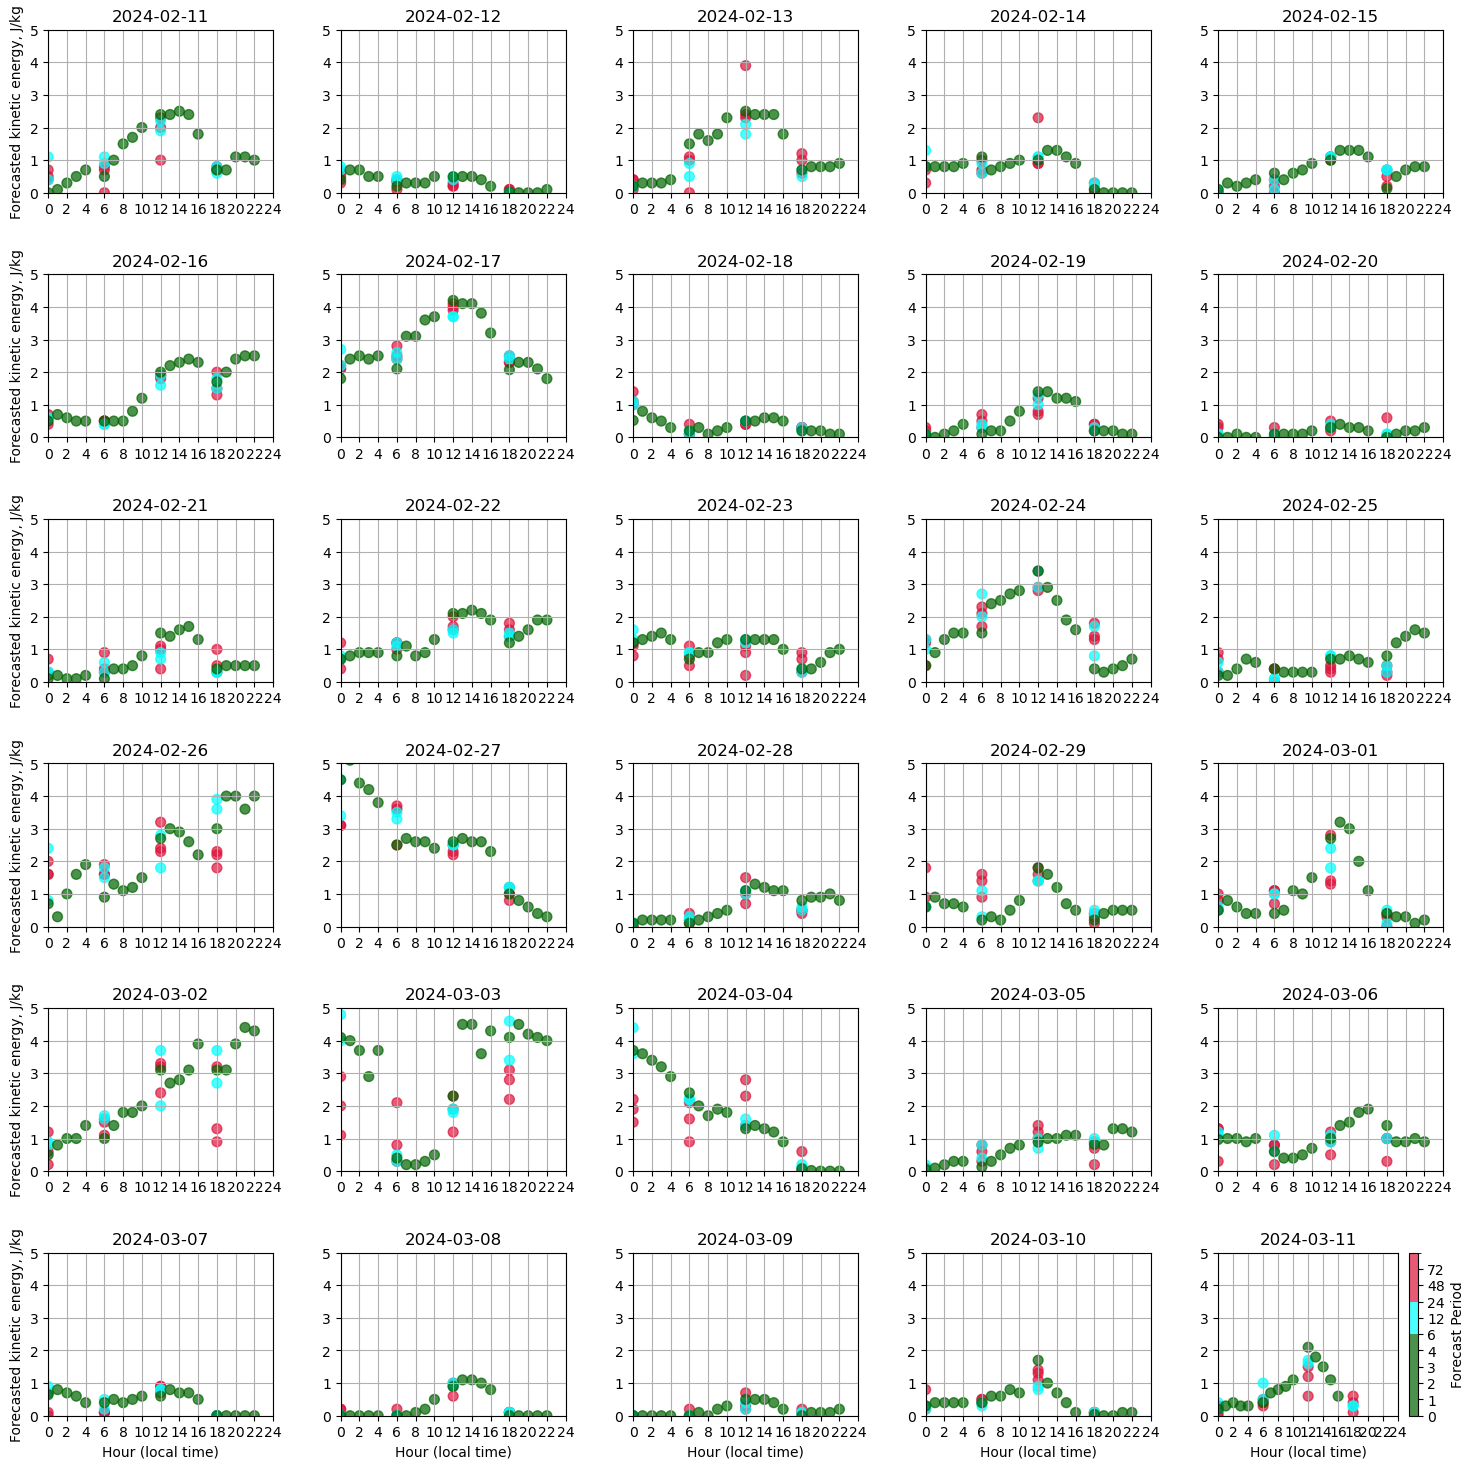

In [113]:
fig, axes = plt.subplots(6,5, figsize=(18,18))
#fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)

for j, category in enumerate(dates):
        subset = data_nam[data_nam['date_forecasted']==dates[j]]
        row = j//5
        col = j%5
        ax = axes[row,col] 
        p = ax.scatter(subset['hour_forecasted'], subset['kinetic_e'], alpha=0.7, c=subset['forecast_period'], cmap=cmap, norm=norm, s=50)
        ax.set_title(pd.to_datetime(dates[j]).date())
        ax.set_xlim([0,24])
        ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
        ax.set_ylim([0,5])
        ax.set_yticks([0,1,2,3,4,5])
        ax.grid(True) 
        if row==5:
                ax.set_xlabel('Hour (local time)')
        if col==0:
                ax.set_ylabel('Forecasted kinetic energy, J/kg')
cbar = plt.colorbar(p, ax=ax, boundaries=bounds, ticks=forecast_periods)
cbar.set_label('Forecast Period')

plt.savefig("output/nam_timeseries_ke.png", bbox_inches='tight')

plt.show()


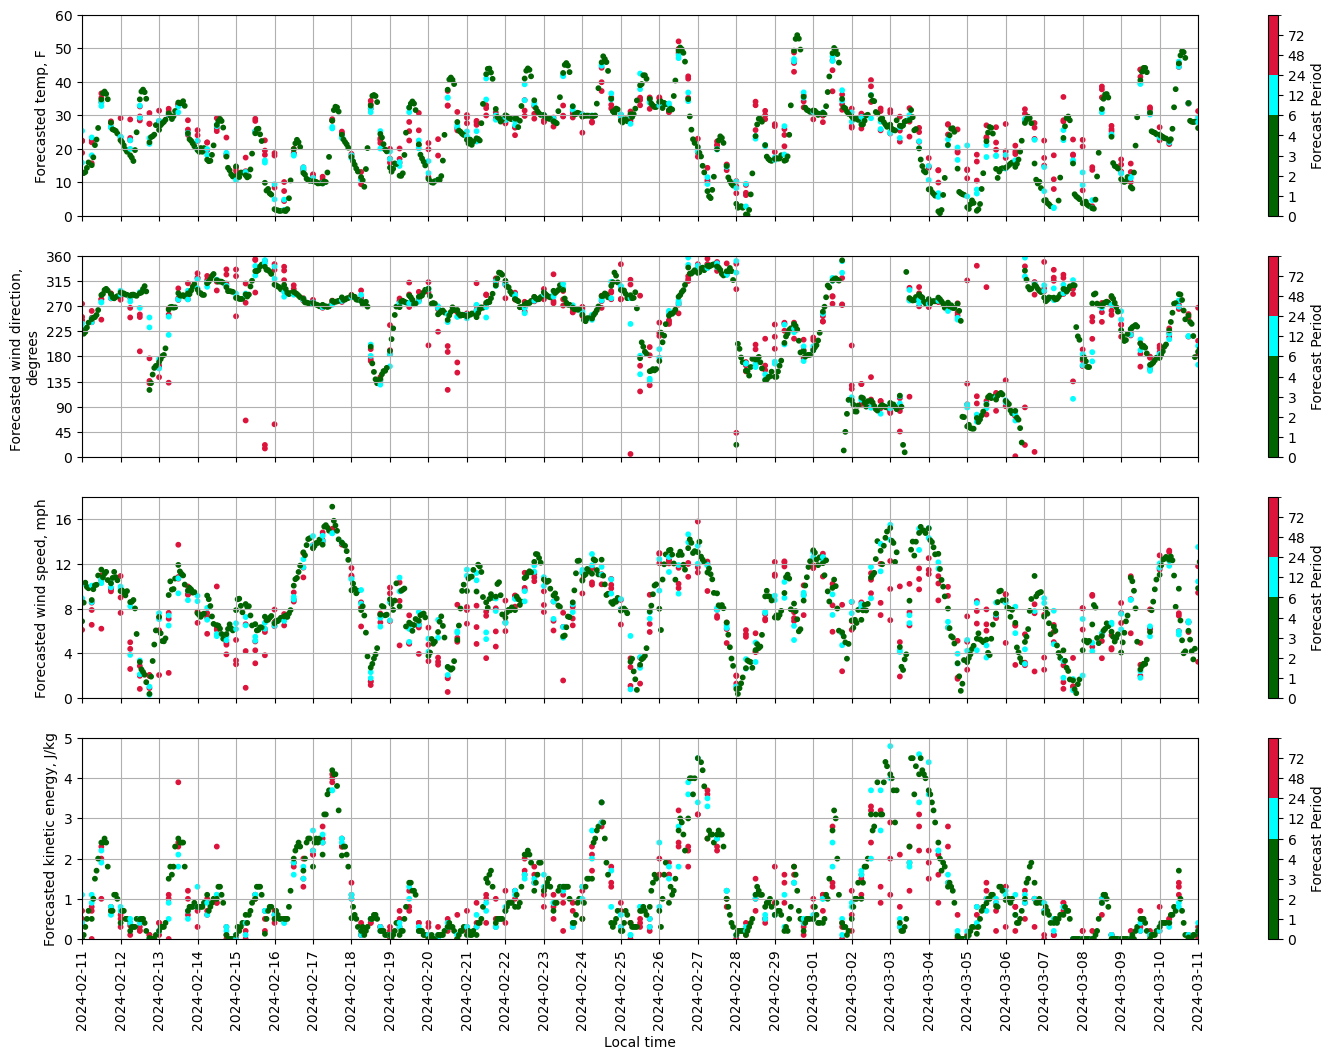

In [114]:
fig, axes = plt.subplots(4,1, figsize=(18,12), sharex=True)

ax = axes[0] 
p = ax.scatter(pd.to_datetime(data_nam['date_forecasted']) + pd.to_timedelta(data_nam['hour_forecasted'], unit='h'), 
               data_nam['temp_F'], alpha=1, c=data_nam['forecast_period'], cmap=cmap, norm=norm, s=10)
ax.set_ylim([0,60])
ax.set_yticks([0,10,20,30,40,50,60])
ax.grid(True) 
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])
# ax.set_xlabel('Local time')
ax.set_ylabel('Forecasted temp, F')
cbar = plt.colorbar(p, ax=ax, boundaries=bounds, ticks=forecast_periods)
cbar.set_label('Forecast Period')

ax = axes[1] 
p = ax.scatter(pd.to_datetime(data_nam['date_forecasted']) + pd.to_timedelta(data_nam['hour_forecasted'], unit='h'), 
               data_nam['wdr'], alpha=1, c=data_nam['forecast_period'], cmap=cmap, norm=norm, s=10)
ax.set_ylim([0,360])
ax.set_yticks([0,45,90,135,180,225,270,315,360])
ax.grid(True) 
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])
# ax.set_xlabel('Local time')
ax.set_ylabel('Forecasted wind direction, \ndegrees')
cbar = plt.colorbar(p, ax=ax, boundaries=bounds, ticks=forecast_periods)
cbar.set_label('Forecast Period')

ax = axes[2] 
p = ax.scatter(pd.to_datetime(data_nam['date_forecasted']) + pd.to_timedelta(data_nam['hour_forecasted'], unit='h'), 
               data_nam['wspd_mph'], alpha=1, c=data_nam['forecast_period'], cmap=cmap, norm=norm,  s=10)
ax.set_ylim([0,18])
ax.set_yticks([0,4,8,12,16])
ax.grid(True) 
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])
# ax.set_xlabel('Local time')
ax.set_ylabel('Forecasted wind speed, mph')
cbar = plt.colorbar(p, ax=ax, boundaries=bounds, ticks=forecast_periods)
cbar.set_label('Forecast Period')

ax = axes[3] 
p = ax.scatter(pd.to_datetime(data_nam['date_forecasted']) + pd.to_timedelta(data_nam['hour_forecasted'], unit='h'), 
               data_nam['kinetic_e'], alpha=1, c=data_nam['forecast_period'], cmap=cmap, norm=norm, s=10)
ax.set_ylim([0,5])
ax.set_yticks([0,1,2,3,4,5])
ax.grid(True) 
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])
ax.set_xticks(dates)
ax.set_xlabel('Local time')
ax.set_ylabel('Forecasted kinetic energy, J/kg')
cbar = plt.colorbar(p, ax=ax, boundaries=bounds, ticks=forecast_periods)
cbar.set_label('Forecast Period')
plt.xticks(rotation=90)

plt.savefig("output/nam_timeseries_all.png", bbox_inches='tight')
plt.show()
